<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 4: Build a Convolution Neural Network

</div>


In [1]:
# Download dataset
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-10-28 18:20:19--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   410MB/s    in 0.2s    

2023-10-28 18:20:24 (410 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-10-28 18:20:24--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## A. Data Loading and Preprocessing

In Convolutional Neural Networks (CNNs), the convolution operation expects the input to have a specific shape, typically denoted as `[batch_size, channels, height, width]`. The "channels" dimension refers to the number of input channels (or depth) of the input data.

For standard RGB images, this channels value is 3 (for red, green, and blue). For grayscale images, there's only one channel. For more specialized data, there could be more channels. For example, medical imaging modalities like MRI or CT can sometimes have multiple channels representing different types of scans or different views of the same scan.

When working with data that doesn't naturally have a channels dimension (e.g., plain grayscale image arrays that are just `[height, width]`), you need to explicitly add a channels dimension to match the expected input format of the CNN. This is done using `.unsqueeze(1)` which adds an additional dimension at the 1st position (0-indexed), converting a shape like `[batch_size, height, width]` to `[batch_size, 1, height, width]`. The "1" here indicates a single channel.


In [33]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
from pytorch_model_summary import summary
from torchvision import transforms
import time

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float().unsqueeze(1)
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks

### 1. Use the **Class**

In PyTorch, we define our custom neural network architectures by subclassing the `nn.Module` class. This gives our neural network all the functionality it needs to work with PyTorch's other utilities and keeps our implementation organized.

- Neural networks are defined by subclassing `nn.Module`.
- The layers of the neural network are initialized in the `__init__` method.
- The forward pass operations on input data are defined in the `forward` method.

It's worth noting that while we only define the forward pass, PyTorch will automatically derive the backward pass for us, which is used during training to update the model's weights."

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 32), # 1st FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 2nd FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 3rd FC
#     nn.ReLU(),
#     nn.Linear(32, 1)          # 4th FC
# ).cuda()

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*256*1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

### 2. ann2cnn

To transition a model from an ANN to a CNN using `nn.Conv2d` layers, we make the following changes:

- Replace `nn.Linear` layers with `nn.Conv2d` layers for the initial layers.
- Add pooling layers after convolutional layers for spatial dimension reduction.
- Introduce a flattening step before transitioning to fully connected layers.
- Adjust the `forward` method to handle the convolutional and pooling operations and reshaping.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 channel, and using 3x3 kernels for simplicity, 256*256
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128*128

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 128*128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*64

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*32

        # Adjust flattened dimensions based on the output size of your last pooling layer
        flattened_dim = 32 * 32 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [14]:
class ConvGAP(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same') ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128*128
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 128*128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*64
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 64*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*32

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1)
        )

    def forward(self, x):

        x = self.net(x)
        return x

## C. Training the Neural Network

`model = model.cuda()` moves the model's parameters and buffers to the GPU memory.

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# Change you model here
model = ConvModel()
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  3%|██▊                                                                                | 1/30 [00:02<01:02,  2.16s/it]

Epoch 1/30, Train loss: 0.6875, Train acc: 56.62%, Val loss: 0.6048, Val acc: 57.00%, Best Val loss: 0.6048 Best Val acc: 57.00%


  7%|█████▌                                                                             | 2/30 [00:04<00:58,  2.07s/it]

Epoch 2/30, Train loss: 0.2960, Train acc: 87.50%, Val loss: 0.3388, Val acc: 86.75%, Best Val loss: 0.3388 Best Val acc: 86.75%


 10%|████████▎                                                                          | 3/30 [00:05<00:52,  1.96s/it]

Epoch 3/30, Train loss: 0.1449, Train acc: 95.06%, Val loss: 0.1452, Val acc: 93.75%, Best Val loss: 0.1452 Best Val acc: 93.75%


 13%|███████████                                                                        | 4/30 [00:08<00:52,  2.03s/it]

Epoch 4/30, Train loss: 0.1094, Train acc: 96.12%, Val loss: 0.1543, Val acc: 93.50%, Best Val loss: 0.1452 Best Val acc: 93.75%


 17%|█████████████▊                                                                     | 5/30 [00:10<00:50,  2.02s/it]

Epoch 5/30, Train loss: 0.1014, Train acc: 96.19%, Val loss: 0.1190, Val acc: 95.50%, Best Val loss: 0.1190 Best Val acc: 95.50%


 20%|████████████████▌                                                                  | 6/30 [00:12<00:50,  2.11s/it]

Epoch 6/30, Train loss: 0.0816, Train acc: 97.62%, Val loss: 0.1831, Val acc: 93.50%, Best Val loss: 0.1190 Best Val acc: 95.50%


 23%|███████████████████▎                                                               | 7/30 [00:14<00:47,  2.09s/it]

Epoch 7/30, Train loss: 0.0554, Train acc: 98.12%, Val loss: 0.1138, Val acc: 96.25%, Best Val loss: 0.1138 Best Val acc: 96.25%


 27%|██████████████████████▏                                                            | 8/30 [00:16<00:45,  2.07s/it]

Epoch 8/30, Train loss: 0.0452, Train acc: 98.44%, Val loss: 0.1213, Val acc: 96.50%, Best Val loss: 0.1138 Best Val acc: 96.50%


 30%|████████████████████████▉                                                          | 9/30 [00:18<00:42,  2.05s/it]

Epoch 9/30, Train loss: 0.0454, Train acc: 98.62%, Val loss: 0.1167, Val acc: 95.75%, Best Val loss: 0.1138 Best Val acc: 96.50%


 33%|███████████████████████████▎                                                      | 10/30 [00:20<00:40,  2.04s/it]

Epoch 10/30, Train loss: 0.0283, Train acc: 98.94%, Val loss: 0.1153, Val acc: 96.25%, Best Val loss: 0.1138 Best Val acc: 96.50%


 37%|██████████████████████████████                                                    | 11/30 [00:22<00:38,  2.02s/it]

Epoch 11/30, Train loss: 0.0203, Train acc: 99.56%, Val loss: 0.1142, Val acc: 96.50%, Best Val loss: 0.1138 Best Val acc: 96.50%


 40%|████████████████████████████████▊                                                 | 12/30 [00:24<00:37,  2.06s/it]

Epoch 12/30, Train loss: 0.0110, Train acc: 99.75%, Val loss: 0.1149, Val acc: 96.50%, Best Val loss: 0.1138 Best Val acc: 96.50%


 43%|███████████████████████████████████▌                                              | 13/30 [00:26<00:35,  2.10s/it]

Epoch 13/30, Train loss: 0.0081, Train acc: 99.81%, Val loss: 0.1137, Val acc: 96.50%, Best Val loss: 0.1137 Best Val acc: 96.50%


 47%|██████████████████████████████████████▎                                           | 14/30 [00:28<00:33,  2.07s/it]

Epoch 14/30, Train loss: 0.0070, Train acc: 99.81%, Val loss: 0.1156, Val acc: 96.50%, Best Val loss: 0.1137 Best Val acc: 96.50%


 50%|█████████████████████████████████████████                                         | 15/30 [00:30<00:30,  2.06s/it]

Epoch 15/30, Train loss: 0.0060, Train acc: 99.94%, Val loss: 0.1162, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:32<00:28,  2.04s/it]

Epoch 16/30, Train loss: 0.0054, Train acc: 99.88%, Val loss: 0.1191, Val acc: 96.50%, Best Val loss: 0.1137 Best Val acc: 96.75%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:34<00:26,  2.03s/it]

Epoch 17/30, Train loss: 0.0049, Train acc: 99.94%, Val loss: 0.1205, Val acc: 96.50%, Best Val loss: 0.1137 Best Val acc: 96.75%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:37<00:24,  2.08s/it]

Epoch 18/30, Train loss: 0.0042, Train acc: 99.94%, Val loss: 0.1213, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:39<00:23,  2.15s/it]

Epoch 19/30, Train loss: 0.0038, Train acc: 99.94%, Val loss: 0.1249, Val acc: 96.50%, Best Val loss: 0.1137 Best Val acc: 96.75%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:41<00:21,  2.11s/it]

Epoch 20/30, Train loss: 0.0035, Train acc: 100.00%, Val loss: 0.1260, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:43<00:19,  2.14s/it]

Epoch 21/30, Train loss: 0.0031, Train acc: 100.00%, Val loss: 0.1260, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:45<00:17,  2.18s/it]

Epoch 22/30, Train loss: 0.0031, Train acc: 100.00%, Val loss: 0.1263, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:48<00:15,  2.21s/it]

Epoch 23/30, Train loss: 0.0030, Train acc: 100.00%, Val loss: 0.1263, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:50<00:12,  2.13s/it]

Epoch 24/30, Train loss: 0.0030, Train acc: 100.00%, Val loss: 0.1265, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:52<00:10,  2.10s/it]

Epoch 25/30, Train loss: 0.0030, Train acc: 100.00%, Val loss: 0.1269, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:54<00:08,  2.14s/it]

Epoch 26/30, Train loss: 0.0029, Train acc: 100.00%, Val loss: 0.1270, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:56<00:06,  2.14s/it]

Epoch 27/30, Train loss: 0.0029, Train acc: 100.00%, Val loss: 0.1273, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:58<00:04,  2.08s/it]

Epoch 28/30, Train loss: 0.0029, Train acc: 100.00%, Val loss: 0.1276, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [01:00<00:02,  2.01s/it]

Epoch 29/30, Train loss: 0.0028, Train acc: 100.00%, Val loss: 0.1278, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:02<00:00,  2.08s/it]

Epoch 30/30, Train loss: 0.0028, Train acc: 100.00%, Val loss: 0.1280, Val acc: 96.75%, Best Val loss: 0.1137 Best Val acc: 96.75%


### Visualizing model performance

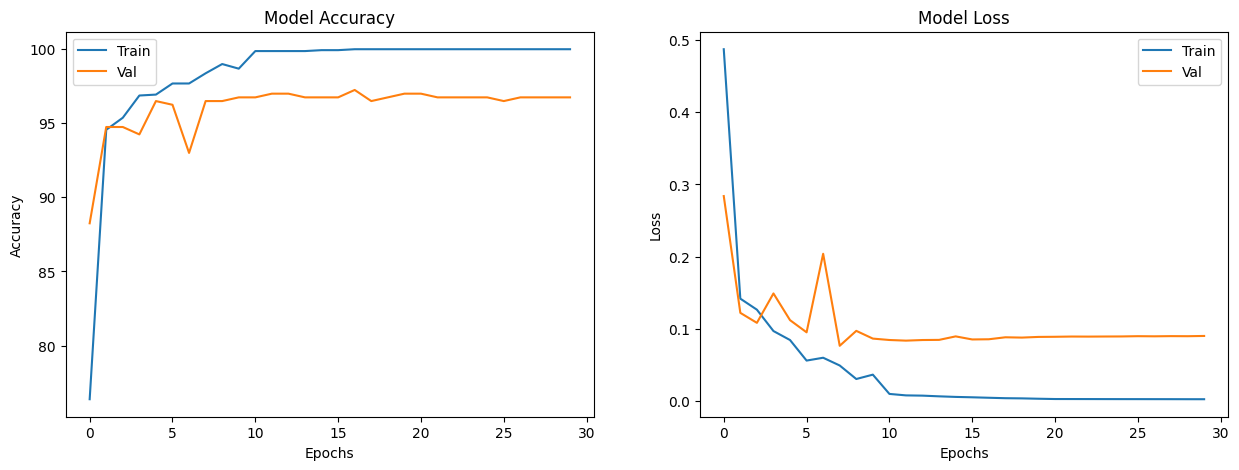

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [14]:
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

### Process Test Dataset

In [9]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).float().unsqueeze(1)
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, 32, shuffle=False)

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


### Load Trained Model and Evaluate

In [17]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()

        outputs = model(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted = torch.sigmoid(outputs) > 0.5

        test_correct += (predicted.float() == labels_float).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 74.75%


## 1.1 Task A: Reduce Overfitting (30 pts)

###

In [19]:
# from torchsummary import summary
# from pytorch_model_summary import summary
model_ConvGAP = ConvGAP()
print(summary(model_ConvGAP.to('cuda'), torch.zeros((1, 1, 256, 256)).to('cuda'), show_input=True))

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 1, 256, 256]             320             320
                 ReLU-2     [1, 32, 256, 256]               0               0
            MaxPool2d-3     [1, 32, 256, 256]               0               0
               Conv2d-4     [1, 32, 128, 128]           9,248           9,248
                 ReLU-5     [1, 32, 128, 128]               0               0
            MaxPool2d-6     [1, 32, 128, 128]               0               0
               Conv2d-7       [1, 32, 64, 64]           9,248           9,248
                 ReLU-8       [1, 32, 64, 64]               0               0
            MaxPool2d-9       [1, 32, 64, 64]               0               0
   AdaptiveAvgPool2d-10       [1, 32, 32, 32]               0               0
             Flatten-11         [1, 32, 1, 1]               0  

In [20]:

class ConvModel_V2(nn.Module):
    def __init__(self, dropout=0, batch_normalization=False, simplify=False):
        super().__init__()

        # 1 channel, and using 3x3 kernels for simplicity, 256*256
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128*128

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 128*128
        
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*64

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64
        
        self.bn3 = nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*32

        # Adjust flattened dimensions based on the output size of your last pooling layer
        flattened_dim = 32 * 32 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        
        self.bn4 = nn.BatchNorm1d(flattened_dim)
        
        self.fc2 = nn.Linear(32, 1)

        # dropout
        self.dropout1 = nn.Dropout(dropout)
        self.batch_normalization = batch_normalization
        self.simplify = simplify


    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        if self.batch_normalization:
            x = self.bn1(x)
        
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        
        if self.batch_normalization:
            x = self.bn2(x)
            
        x = self.pool2(x)
        
        if self.simplify:
            x = F.relu(self.conv3(x))

            if self.batch_normalization:
                x = self.bn3(x)

            x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        if self.batch_normalization:
            x = self.bn4(x)
            
        # add dropout1
        x = self.dropout1(x)

        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [21]:
def training(model, epochs=30, weight_decay=0, early_stop=False,
             train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, serial_no=None):

    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    # epochs = 30

    # Change you model here
    # model = ConvModel()
    print(model)
    model = model.cuda()

    best_val_loss = float('inf')
    best_val_acc = -1

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)
    # lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
    lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        total_loss = 0.0
        train_correct = 0
        total_train_samples = 0

        for images, labels in train_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            train_predicted = torch.sigmoid(outputs) > 0.5
            train_correct += (train_predicted.float() == labels).sum().item()
            total_train_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100. * train_correct / total_train_samples

        # Validation
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.cuda()
                images = images / 255.
                labels = labels.cuda()
                outputs = model(images)

                labels = labels.float().unsqueeze(1)

                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                predicted = torch.sigmoid(outputs) > 0.5
                correct += (predicted.float() == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100. * correct / total
        
        # test evaluation
        total_test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.cuda()
                images = images / 255.
                labels = labels.cuda()
                outputs = model(images)

                labels = labels.float().unsqueeze(1)

                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                predicted = torch.sigmoid(outputs) > 0.5
                correct += (predicted.float() == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100. * correct / total
        

        # Learning rate update
        lr_scheduler.step()

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'model_classification.pth')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy

        print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

        # Store performance
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting training and validation accuracy
    labels = ['Train', 'Val']
    ax[0].plot(train_accuracies)
    ax[0].plot(val_accuracies)
#     ax[0].plot(test_accuracies)
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(labels)

    # Plotting training and validation loss
    ax[1].plot(train_losses)
    ax[1].plot(val_losses)
#     ax[1].plot(test_losses)
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(labels)
    
    if serial_no:
        plt.savefig(f'./assets/images/original_model_learning_curve_{serial_no}.png')
    
    plt.show()
    
    # Load the trained weights
    model.load_state_dict(torch.load('model_classification.pth'))

    # Set the model to evaluation mode
    model.eval()

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:

            images = images.cuda()
            images = images / 255.

            labels = labels.cuda()

            outputs = model(images)

            labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
            predicted = torch.sigmoid(outputs) > 0.5

            test_correct += (predicted.float() == labels_float).sum().item()
            test_total += labels.size(0)

    print(f'Test accuracy is {100. * test_correct / test_total}%')
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies, best_val_loss, best_val_acc

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.6177, Train acc: 68.50%, Val loss: 0.4284, Val acc: 88.25%, Best Val loss: 0.4284 Best Val acc: 88.25%
Epoch 2/30, Train loss: 0.4309, Train acc: 88.62%, Val loss: 0.3811, Val acc: 93.00%, Best Val loss: 0.3811 Best Val acc: 93.00%
Epoch 3/30, Train loss: 0.3620, Train acc: 94.81%, Val loss: 0.3542, Val acc: 95.00%, Best Val loss: 0.3542 Best Val acc: 95.00%
Epoch 4/30, Train loss: 0.3460, Train acc: 95.31%, Val loss: 0.3477, Val acc: 94.25%, Best Val loss: 0.3477 Best Val acc: 95.00%
Epoch 5/30, Train loss: 0.3213, Train acc: 96.00%, Val loss: 0.3184, Val acc: 95.50%, Best Val loss: 0.3184 Best Val acc: 95.50%
Epoch 6/30, Train loss: 0.3066, Train acc: 96.75%, Val loss: 0.3103, Val acc: 95.75%, Best Val loss: 0.3103 Best Val acc: 95.75%
Epoch 7/30, Train loss: 0.2850, Train acc: 97.38%, Val loss: 0.3124, Val acc: 95.25%, Best Val loss: 0.3103 Best Val acc: 95.75%
Epoch 8/30, Train loss: 0.2728, Train acc: 97.44%, Val loss: 0.2911, Val acc: 95.50%, Best Val lo

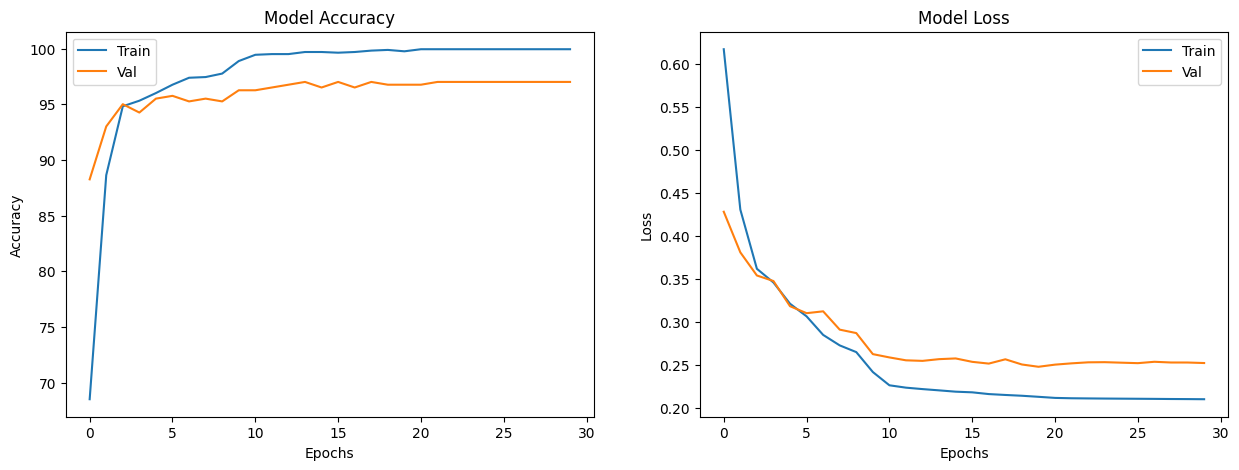

Test accuracy is 79.0%


In [203]:
# Original ConvModel

model_ConvModel = ConvModel_V2()

m_ConvModel_original = training(model=model_ConvModel, epochs=30, serial_no='002')

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.4875, Train acc: 74.50%, Val loss: 0.2153, Val acc: 91.25%, Best Val loss: 0.2153 Best Val acc: 91.25%
Epoch 2/30, Train loss: 0.1812, Train acc: 93.38%, Val loss: 0.1172, Val acc: 95.00%, Best Val loss: 0.1172 Best Val acc: 95.00%
Epoch 3/30, Train loss: 0.0973, Train acc: 96.19%, Val loss: 0.1192, Val acc: 95.75%, Best Val loss: 0.1172 Best Val acc: 95.75%
Epoch 4/30, Train loss: 0.1005, Train acc: 95.88%, Val loss: 0.1217, Val acc: 95.50%, Best Val loss: 0.1172 Best Val acc: 95.75%
Epoch 5/30, Train loss: 0.1479, Train acc: 94.94%, Val loss: 0.1421, Val acc: 94.25%, Best Val loss: 0.1172 Best Val acc: 95.75%
Epoch 6/30, Train loss: 0.0717, Train acc: 97.31%, Val loss: 0.0897, Val acc: 97.00%, Best Val loss: 0.0897 Best Val acc: 97.00%
Epoch 7/30, Train loss: 0.0772, Train acc: 97.25%, Val loss: 0.1186, Val acc: 95.75%, Best Val loss: 0.0897 Best Val acc: 97.00%
Epoch 8/30, Train loss: 0.0653, Train acc: 97.56%, Val loss: 0.1346, Val acc: 95.00%, Best Val lo

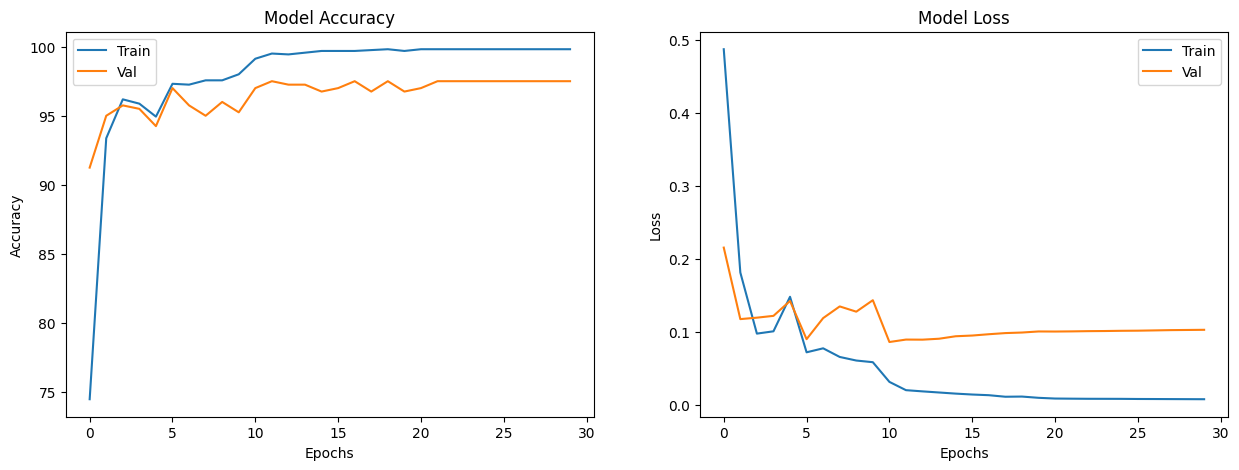

Test accuracy is 74.5%


In [211]:
# Original ConvModel

model_ConvModel_003 = ConvModel_V2()

m_ConvModel_original_003 = training(model=model_ConvModel_003, epochs=30, serial_no='003')

In [212]:
print(m_ConvModel_original)

(ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(

### Weight Decay

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.4742, Train acc: 76.94%, Val loss: 0.4394, Val acc: 82.00%, Best Val loss: 0.4394 Best Val acc: 82.00%
Epoch 2/30, Train loss: 0.1971, Train acc: 92.88%, Val loss: 0.2013, Val acc: 91.00%, Best Val loss: 0.2013 Best Val acc: 91.00%
Epoch 3/30, Train loss: 0.2170, Train acc: 91.81%, Val loss: 0.2635, Val acc: 89.75%, Best Val loss: 0.2013 Best Val acc: 91.00%
Epoch 4/30, Train loss: 0.1712, Train acc: 93.81%, Val loss: 0.1769, Val acc: 93.25%, Best Val loss: 0.1769 Best Val acc: 93.25%
Epoch 5/30, Train loss: 0.1527, Train acc: 94.12%, Val loss: 0.1698, Val acc: 94.00%, Best Val loss: 0.1698 Best Val acc: 94.00%
Epoch 6/30, Train loss: 0.1423, Train acc: 94.62%, Val loss: 0.1839, Val acc: 93.25%, Best Val loss: 0.1698 Best Val acc: 94.00%
Epoch 7/30, Train loss: 0.1517, Train acc: 94.12%, Val loss: 0.1907, Val acc: 93.50%, Best Val loss: 0.1698 Best Val acc: 94.00%
Epoch 8/30, Train loss: 0.1494, Train acc: 93.56%, Val loss: 0.1905, Val acc: 92.00%, Best Val lo

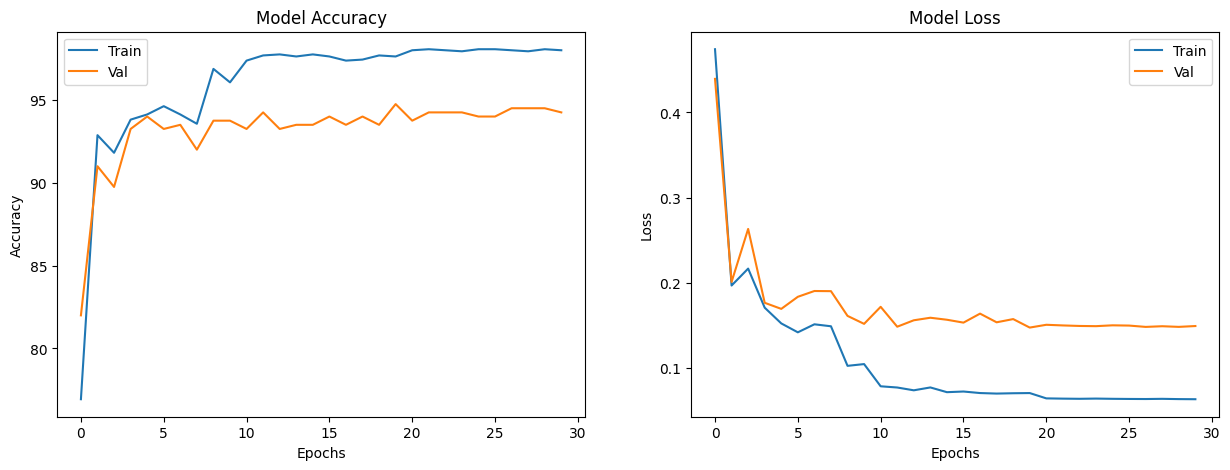

Test accuracy is 77.5%


In [206]:
# Weight Decay

model_ConvModel_weight_decay_0_01 = ConvModel_V2()

m_ConvModel_weight_decay_0_01 = training(model=model_ConvModel_weight_decay_0_01, epochs=30, weight_decay=0.01, serial_no='weight_decay_0_01_002')

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.4446, Train acc: 78.31%, Val loss: 0.1991, Val acc: 92.50%, Best Val loss: 0.1991 Best Val acc: 92.50%
Epoch 2/30, Train loss: 0.1658, Train acc: 93.31%, Val loss: 0.1598, Val acc: 93.25%, Best Val loss: 0.1598 Best Val acc: 93.25%
Epoch 3/30, Train loss: 0.1186, Train acc: 95.38%, Val loss: 0.1159, Val acc: 95.25%, Best Val loss: 0.1159 Best Val acc: 95.25%
Epoch 4/30, Train loss: 0.0963, Train acc: 96.31%, Val loss: 0.1344, Val acc: 94.25%, Best Val loss: 0.1159 Best Val acc: 95.25%
Epoch 5/30, Train loss: 0.0894, Train acc: 96.62%, Val loss: 0.2925, Val acc: 90.75%, Best Val loss: 0.1159 Best Val acc: 95.25%
Epoch 6/30, Train loss: 0.0957, Train acc: 96.06%, Val loss: 0.1341, Val acc: 95.00%, Best Val loss: 0.1159 Best Val acc: 95.25%
Epoch 7/30, Train loss: 0.0829, Train acc: 96.94%, Val loss: 0.1414, Val acc: 93.25%, Best Val loss: 0.1159 Best Val acc: 95.25%
Epoch 8/30, Train loss: 0.0874, Train acc: 97.19%, Val loss: 0.1330, Val acc: 94.25%, Best Val lo

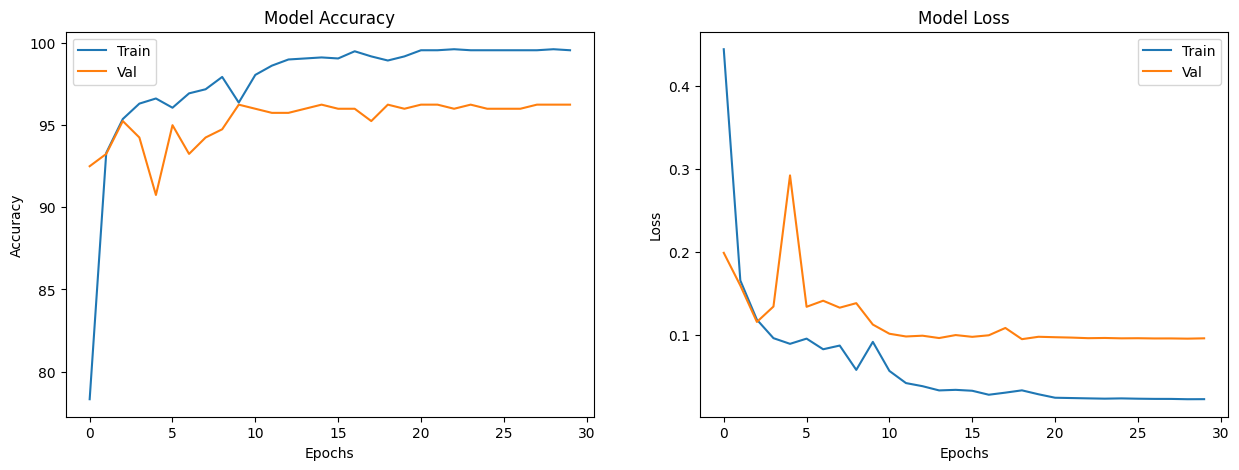

Test accuracy is 75.0%


In [215]:
# Weight Decay

model_ConvModel_weight_decay_0_005_003 = ConvModel_V2()

m_ConvModel_weight_decay_0_005_003 = training(model=model_ConvModel_weight_decay_0_005_003, epochs=30, weight_decay=0.005, serial_no='weight_decay_0_005_003')

In [216]:
print(m_ConvModel_weight_decay_0_01)

(ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(

In [76]:
def compare_learning_curve(model_1_list, model_2_list, serial_no='000', labels=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    if not labels:
        labels = [
                  'Original_Train', 'Original_Val', 'Original_best',
                  'Weight_Decay_Train', 'Weight_Decay_Val', 'Weight_Decay_best'
                 ]
    
    # Plotting training and validation accuracy
    ax[0].plot(model_1_list[2], color='blue', linestyle='--')
    ax[0].plot(model_1_list[4], color='blue', linestyle='-')

    ax[0].axvline(x=model_1_list[4].index(model_1_list[8]), color='blue', linestyle='-')    
    
    ax[0].plot(model_2_list[2], color='green', linestyle='--')
    ax[0].plot(model_2_list[4], color='green', linestyle='-')

    ax[0].axvline(x=model_2_list[4].index(model_2_list[8]), color='green', linestyle='-')
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(labels, loc='lower right')
    
    # Plotting training and validation loss
    ax[1].plot(model_1_list[1], color='blue', linestyle='--')
    ax[1].plot(model_1_list[3], color='blue', linestyle='-')

    ax[1].axvline(x=model_1_list[3].index(model_1_list[7]), color='blue', linestyle='-')    
    
    ax[1].plot(model_2_list[1], color='green', linestyle='--')
    ax[1].plot(model_2_list[3], color='green', linestyle='-')

    ax[1].axvline(x=model_2_list[3].index(model_2_list[7]), color='green', linestyle='-')
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')

    ax[1].legend(labels, loc='upper right')
    
    plt.savefig(f'./assets/images/task_a_fig_1_compare_learning_curve_{serial_no}.png')

    plt.show()

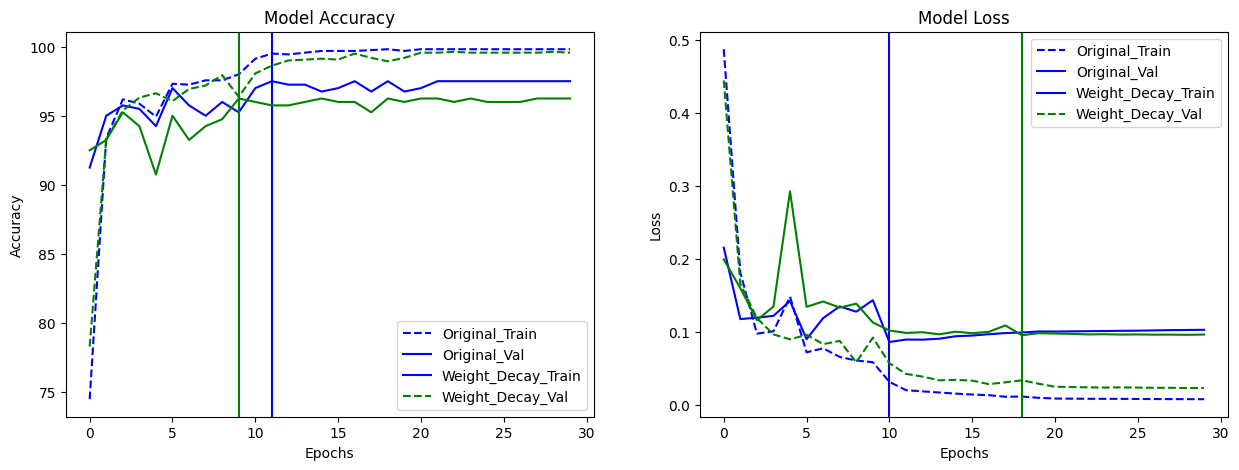

In [222]:
compare_learning_curve(m_ConvModel_original_003, m_ConvModel_weight_decay_0_005_003, 'weight_decay_0_005_003')

In [57]:
def compare_generalization(model_1_list, model_2_list, serial_no='000', labels=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    if not labels:
        labels = [
                  'Original_Val', 'Original_Test', 'Original_Best'
                  'Weight_Decay_Val', 'Weight_Decay_Test', 'Weight_Decay_Best'
                 ]
    
    
    # Plotting training and validation accuracy
#     ax[0].plot(model_1_list[2], color='blue', linestyle='--')
    ax[0].plot(model_1_list[4], color='blue', linestyle='-')
    ax[0].plot(model_1_list[6], color='blue', linestyle='-.')
    ax[0].axvline(x=(best_epoch_0_1 := model_1_list[4].index(model_1_list[8])), color='blue', linestyle='-')    
    
#     ax[0].plot(model_2_list[2], color='green', linestyle='--')
    ax[0].plot(model_2_list[4], color='green', linestyle='-')
    ax[0].plot(model_2_list[6], color='green', linestyle='-.')
    ax[0].axvline(x=(best_epoch_0_2 := model_2_list[4].index(model_2_list[8])), color='green', linestyle='-')
    
    # Specify the location (x, y) for the text and the text content
    x_location_0_1 = best_epoch_0_1 + 0.5
    best_test_0_1 = model_1_list[6][best_epoch_0_1]
    y_location_0_1 = best_test_0_1 - 3
    text_content_0_1 = 'test accuracy \n' + str(best_test_0_1) + '%'
    # Add the text annotation to the plot
    ax[0].text(x_location_0_1, y_location_0_1, text_content_0_1, fontsize=10, color='blue')

    # Specify the location (x, y) for the text and the text content
    x_location_0_2 = best_epoch_0_2 + 0.5
    best_test_0_2 = model_2_list[6][best_epoch_0_2]
    y_location_0_2 = best_test_0_1 + 4
    text_content_0_2 = 'test accuracy \n' + str(best_test_0_2) + '%'
    # Add the text annotation to the plot
    ax[0].text(x_location_0_2, y_location_0_2, text_content_0_2, fontsize=10, color='green')
    
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(labels, loc='upper right')
    
    # Plotting training and validation loss
#     ax[1].plot(model_1_list[1], color='blue', linestyle='--')
    ax[1].plot(model_1_list[3], color='blue', linestyle='-')
    ax[1].plot(model_1_list[5], color='blue', linestyle='-.')
    ax[1].axvline(x=(best_epoch_1_1 := model_1_list[3].index(model_1_list[7])), color='blue', linestyle='-')    
    
#     ax[1].plot(model_2_list[1], color='green', linestyle='--')
    ax[1].plot(model_2_list[3], color='green', linestyle='-')
    ax[1].plot(model_2_list[5], color='green', linestyle='-.')
    ax[1].axvline(x=(best_epoch_1_2 := model_2_list[3].index(model_2_list[7])), color='green', linestyle='-')
    
    # Specify the location (x, y) for the text and the text content
    x_location_1_1 = best_epoch_1_1 + 0.7
    best_test_1_1 = model_1_list[5][best_epoch_1_1]
    y_location_1_1 = best_test_1_1 - 0.2
    text_content_1_1 = f'test loss \n{best_test_1_1:.2f}%'
    # Add the text annotation to the plot
    ax[1].text(x_location_1_1, y_location_1_1, text_content_1_1, fontsize=10, color='blue')

    # Specify the location (x, y) for the text and the text content
    x_location_1_2 = best_epoch_1_2 + 0.5
    best_test_1_2 = model_2_list[5][best_epoch_1_2]
    y_location_1_2 = best_test_1_2 + 0.15
    text_content_1_2 = f'test loss \n{best_test_1_2:.2f}%'
    # Add the text annotation to the plot
    ax[1].text(x_location_1_2, y_location_1_2, text_content_1_2, fontsize=10, color='green')
    
    print(x_location_1_1, y_location_1_1, text_content_1_1)
    print(x_location_1_2, y_location_1_2, text_content_1_2)
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(labels, loc='upper right')

    plt.savefig(f'./assets/images/task_a_fig_2_compare_generalization_{serial_no}.png')
    plt.show()

10.7 1.0568095255578205 test loss 
1.26%
18.5 1.2192028700947188 test loss 
1.07%


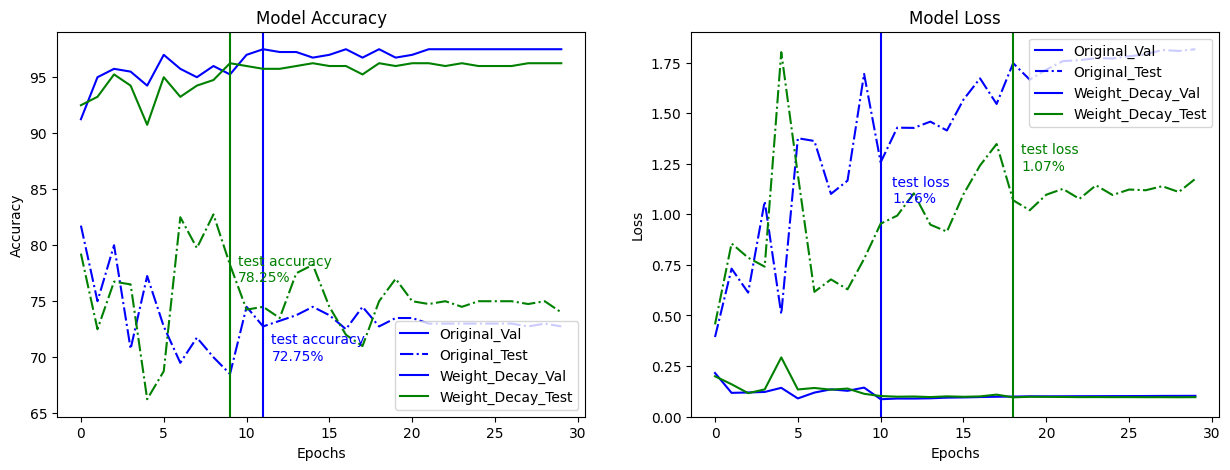

In [221]:
compare_generalization(m_ConvModel_original_003, m_ConvModel_weight_decay_0_005_003, 'weight_decay_0_005_003')

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.5071, Train acc: 73.81%, Val loss: 0.2690, Val acc: 89.75%, Best Val loss: 0.2690 Best Val acc: 89.75%
Epoch 2/30, Train loss: 0.1613, Train acc: 94.12%, Val loss: 0.1437, Val acc: 94.50%, Best Val loss: 0.1437 Best Val acc: 94.50%
Epoch 3/30, Train loss: 0.1012, Train acc: 96.19%, Val loss: 0.1216, Val acc: 95.00%, Best Val loss: 0.1216 Best Val acc: 95.00%
Epoch 4/30, Train loss: 0.0864, Train acc: 96.44%, Val loss: 0.1608, Val acc: 94.00%, Best Val loss: 0.1216 Best Val acc: 95.00%
Epoch 5/30, Train loss: 0.0764, Train acc: 97.06%, Val loss: 0.1241, Val acc: 95.00%, Best Val loss: 0.1216 Best Val acc: 95.00%
Epoch 6/30, Train loss: 0.0566, Train acc: 97.88%, Val loss: 0.1257, Val acc: 94.75%, Best Val loss: 0.1216 Best Val acc: 95.00%
Epoch 7/30, Train loss: 0.0726, Train acc: 97.06%, Val loss: 0.1125, Val acc: 95.75%, Best Val loss: 0.1125 Best Val acc: 95.75%
Epoch 8/30, Train loss: 0.0692, Train acc: 97.31%, Val loss: 0.1164, Val acc: 95.25%, Best Val lo

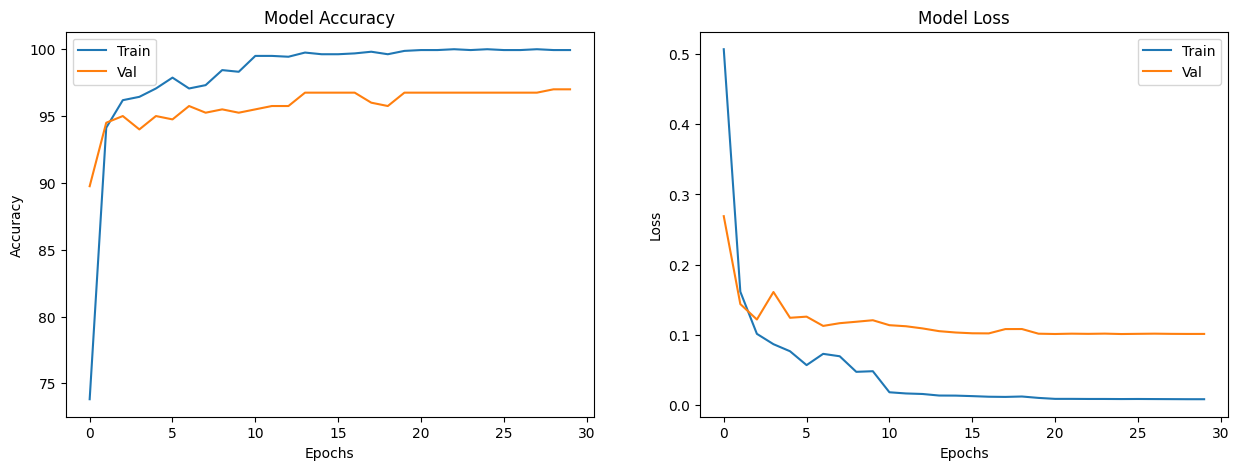

Test accuracy is 73.0%


In [67]:
model_ConvModel_weight_decay = ConvModel()
model_ConvModel_weight_decay = training(model=model_ConvModel_weight_decay, epochs=30, weight_decay=0.001)

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.5501, Train acc: 67.62%, Val loss: 0.2731, Val acc: 88.75%, Best Val loss: 0.2731 Best Val acc: 88.75%
Epoch 2/30, Train loss: 0.2508, Train acc: 89.69%, Val loss: 0.3273, Val acc: 84.50%, Best Val loss: 0.2731 Best Val acc: 88.75%
Epoch 3/30, Train loss: 0.2132, Train acc: 92.31%, Val loss: 0.2828, Val acc: 89.00%, Best Val loss: 0.2731 Best Val acc: 89.00%
Epoch 4/30, Train loss: 0.2030, Train acc: 91.56%, Val loss: 0.2287, Val acc: 90.75%, Best Val loss: 0.2287 Best Val acc: 90.75%
Epoch 5/30, Train loss: 0.1850, Train acc: 93.25%, Val loss: 0.1740, Val acc: 94.00%, Best Val loss: 0.1740 Best Val acc: 94.00%
Epoch 6/30, Train loss: 0.1837, Train acc: 92.94%, Val loss: 0.2769, Val acc: 89.00%, Best Val loss: 0.1740 Best Val acc: 94.00%
Epoch 7/30, Train loss: 0.1702, Train acc: 93.50%, Val loss: 0.2314, Val acc: 92.00%, Best Val loss: 0.1740 Best Val acc: 94.00%
Epoch 8/30, Train loss: 0.1721, Train acc: 93.69%, Val loss: 0.1766, Val acc: 92.75%, Best Val lo

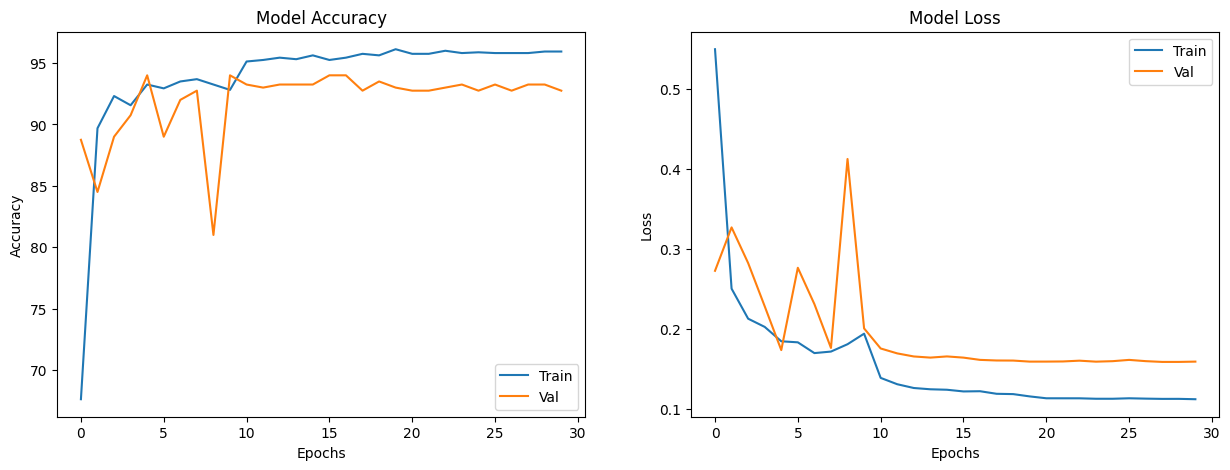

Test accuracy is 73.75%


In [22]:
model_ConvModel_weight_decay_0_05 = ConvModel()
model_ConvModel_weight_decay_0_05 = training(model=model_ConvModel_weight_decay_0_05, epochs=30, weight_decay=0.05)

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.6400, Train acc: 59.19%, Val loss: 0.2994, Val acc: 87.50%, Best Val loss: 0.2994 Best Val acc: 87.50%
Epoch 2/30, Train loss: 0.2570, Train acc: 88.69%, Val loss: 0.2081, Val acc: 92.75%, Best Val loss: 0.2081 Best Val acc: 92.75%
Epoch 3/30, Train loss: 0.2317, Train acc: 91.31%, Val loss: 0.3409, Val acc: 86.50%, Best Val loss: 0.2081 Best Val acc: 92.75%
Epoch 4/30, Train loss: 0.1872, Train acc: 92.94%, Val loss: 0.1996, Val acc: 92.75%, Best Val loss: 0.1996 Best Val acc: 92.75%
Epoch 5/30, Train loss: 0.1599, Train acc: 93.50%, Val loss: 0.2677, Val acc: 91.25%, Best Val loss: 0.1996 Best Val acc: 92.75%
Epoch 6/30, Train loss: 0.1480, Train acc: 94.94%, Val loss: 0.2272, Val acc: 92.00%, Best Val loss: 0.1996 Best Val acc: 92.75%
Epoch 7/30, Train loss: 0.1680, Train acc: 93.50%, Val loss: 0.1620, Val acc: 93.75%, Best Val loss: 0.1620 Best Val acc: 93.75%
Epoch 8/30, Train loss: 0.1241, Train acc: 95.19%, Val loss: 0.1722, Val acc: 94.00%, Best Val lo

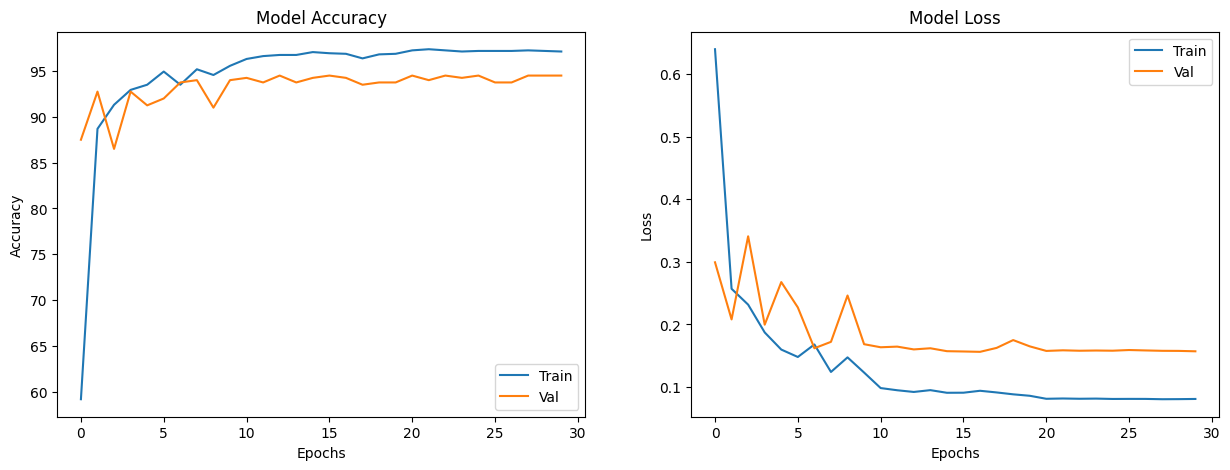

Test accuracy is 74.25%


In [23]:
model_ConvModel_weight_decay_0_02 = ConvModel()
model_ConvModel_weight_decay_0_02 = training(model=model_ConvModel_weight_decay_0_02, epochs=30, weight_decay=0.02)

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.3531, Train acc: 83.25%, Val loss: 0.2724, Val acc: 89.75%, Best Val loss: 0.2724 Best Val acc: 89.75%
Epoch 2/30, Train loss: 0.2671, Train acc: 90.06%, Val loss: 0.1982, Val acc: 92.00%, Best Val loss: 0.1982 Best Val acc: 92.00%
Epoch 3/30, Train loss: 0.1636, Train acc: 93.50%, Val loss: 0.1873, Val acc: 93.00%, Best Val loss: 0.1873 Best Val acc: 93.00%
Epoch 4/30, Train loss: 0.1576, Train acc: 94.75%, Val loss: 0.1709, Val acc: 94.00%, Best Val loss: 0.1709 Best Val acc: 94.00%
Epoch 5/30, Train loss: 0.1524, Train acc: 94.31%, Val loss: 0.1840, Val acc: 93.50%, Best Val loss: 0.1709 Best Val acc: 94.00%
Epoch 6/30, Train loss: 0.1470, Train acc: 94.00%, Val loss: 0.1796, Val acc: 94.50%, Best Val loss: 0.1709 Best Val acc: 94.50%
Epoch 7/30, Train loss: 0.1526, Train acc: 93.75%, Val loss: 0.1951, Val acc: 93.00%, Best Val loss: 0.1709 Best Val acc: 94.50%
Epoch 8/30, Train loss: 0.1925, Train acc: 92.44%, Val loss: 0.1617, Val acc: 93.50%, Best Val lo

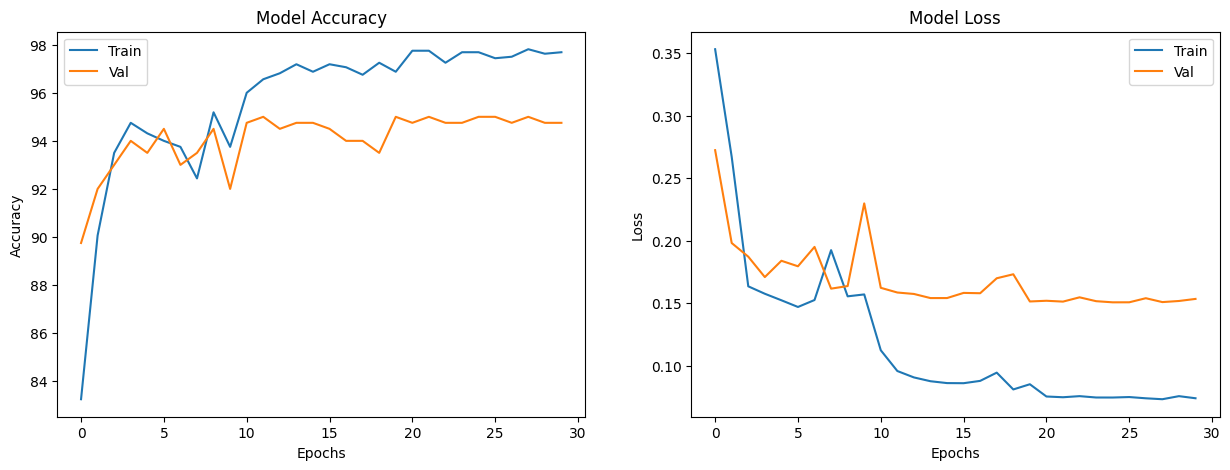

Test accuracy is 76.25%


In [56]:
model_ConvModel_weight_decay_0_015 = ConvModel()
model_ConvModel_weight_decay_0_015 = training(model=model_ConvModel_weight_decay_0_015, epochs=30, weight_decay=0.015)

### Batch Normalization

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0, inplace=False)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.2598, Train acc: 91.12%, Val loss: 0.1977, Val acc: 95.25%, Best Val loss: 0.1977 Best Val acc: 95.25%
Epoch 2/30, Train loss: 0.0851, Train acc: 96.56%, Val loss: 0.0836, Val acc: 95.75%, Best Val loss: 0.0836 Best Val acc: 95.75%
Epoch 3/30, Train loss: 0.0479, Train acc: 98.75%, Val loss: 0.1191, Val acc: 96.00%, Best Val loss: 0.0836 Best Val acc: 96.00%
Epoch 4/30, Train loss: 0.0375, Train acc: 98.56%, Val loss: 0.0997, Val acc: 96.75%, Best Val loss: 0.0836 Best Val acc: 96.75%
Epoch 5/30, Train loss: 0.0202, Train acc: 99.12%, Val loss: 0.0653, Val acc: 96.75%, Best Val loss: 0.0653 Best Val acc: 96.75%
Epoch 6/30, Train loss: 0.0076, Train acc: 99.75%, Val loss: 0.1007, Val acc: 96.50%, Best Val loss: 0.0653 Best Val acc: 96.75%
Epoch 7/30, Train loss: 0.0136, Train acc: 99.50%, Val loss: 0.1309, Val acc: 96.25%, Best Val loss: 0.0653 Best Val acc: 96.75%
Epoch 8/30, Train loss: 0.0173, Train acc: 99.50%, Val loss: 0.1549, Val acc: 96.00%, Best Val lo

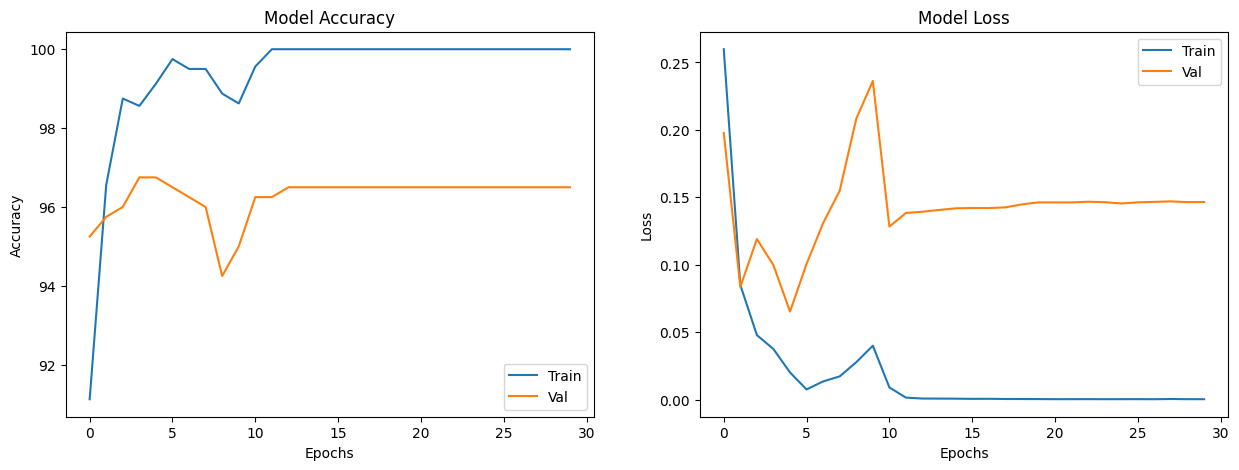

Test accuracy is 73.75%


In [27]:
model_ConvModel_V2_batch_normalization = ConvModel_V2(0, 1)
model_ConvModel_V2_batch_normalization = training(model=model_ConvModel_V2_batch_normalization, epochs=30, weight_decay=0)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.2914, Train acc: 91.31%, Val loss: 5.3400, Val acc: 50.25%, Best Val loss: 5.3400 Best Val acc: 50.25%
Epoch 2/30, Train loss: 0.0757, Train acc: 97.81%, Val loss: 0.1842, Val acc: 95.25%, Best Val loss: 0.1842 Best Val acc: 95.25%
Epoch 3/30, Train loss: 0.0485, Train acc: 98.44%, Val loss: 0.1456, Val acc: 96.50%, Best Val loss: 0.1456 Best Val acc: 96.50%
Epoch 4/30, Train loss: 0.0313, Train acc: 98.88%, Val loss: 0.1422, Val acc: 96.25%, Best Val loss: 0.1422 Best Val acc: 96.50%
Epoch 5/30, Train loss: 0.0429, Train acc: 98.88%, Val loss: 0.1604, Val acc: 96.50%, Best Val loss: 0.1422 Best Val acc: 96.50%
Epoch 6/30, Train loss: 0.0222, Train acc: 99.19%, Val loss: 0.4443, Val acc: 90.00%, Best Val loss: 0.1422 Best Val acc: 96.50%
Epoch 7/30, Train loss: 0.0548, Train acc: 98.56%, Val loss: 0.1483, Val acc: 96.75%, Best Val loss: 0.1422 Best Val acc: 96.75%
Epoch 8/30, Train loss: 0.0333, Train acc: 99.00%, Val loss: 0.0902, Val acc: 98.00%, Best Val lo

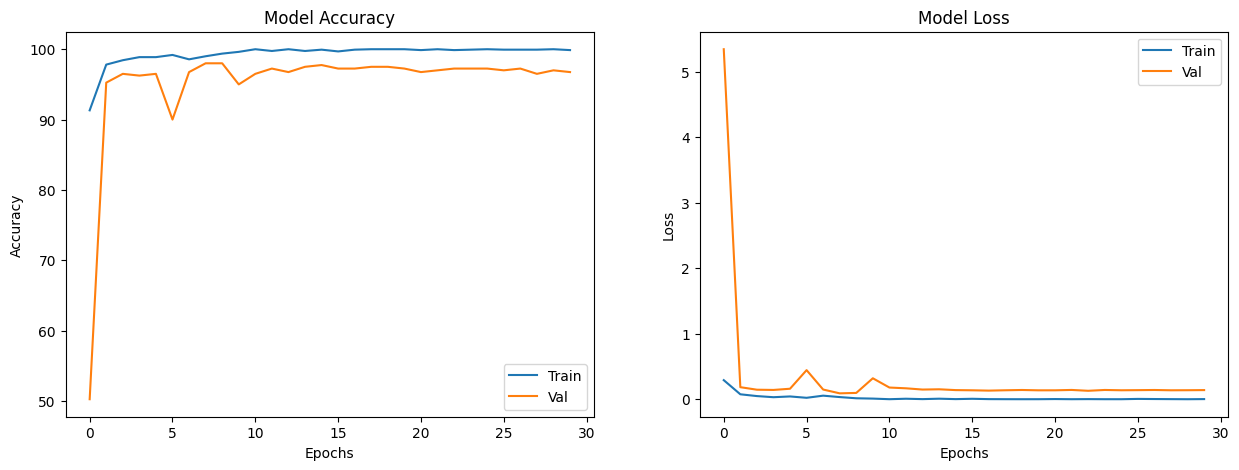

Test accuracy is 74.25%


In [29]:
model_ConvModel_V2_batch_normalization_a = ConvModel_V2(0, 1)
model_ConvModel_V2_batch_normalization_a = training(model=model_ConvModel_V2_batch_normalization_a, epochs=30, weight_decay=0)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.2862, Train acc: 91.88%, Val loss: 0.3617, Val acc: 89.50%, Best Val loss: 0.3617 Best Val acc: 89.50%
Epoch 2/30, Train loss: 0.0984, Train acc: 96.31%, Val loss: 0.2215, Val acc: 93.75%, Best Val loss: 0.2215 Best Val acc: 93.75%
Epoch 3/30, Train loss: 0.0675, Train acc: 97.50%, Val loss: 0.1164, Val acc: 96.25%, Best Val loss: 0.1164 Best Val acc: 96.25%
Epoch 4/30, Train loss: 0.0631, Train acc: 97.69%, Val loss: 0.0980, Val acc: 95.50%, Best Val loss: 0.0980 Best Val acc: 96.25%
Epoch 5/30, Train loss: 0.0254, Train acc: 99.25%, Val loss: 0.1080, Val acc: 96.50%, Best Val loss: 0.0980 Best Val acc: 96.50%
Epoch 6/30, Train loss: 0.0193, Train acc: 99.62%, Val loss: 0.0942, Val acc: 97.50%, Best Val loss: 0.0942 Best Val acc: 97.50%
Epoch 7/30, Train loss: 0.0187, Train acc: 99.44%, Val loss: 0.1243, Val acc: 95.75%, Best Val loss: 0.0942 Best Val acc: 97.50%
Epoch 8/30, Train loss: 0.0342, Train acc: 99.06%, Val loss: 0.1858, Val acc: 93.75%, Best Val lo

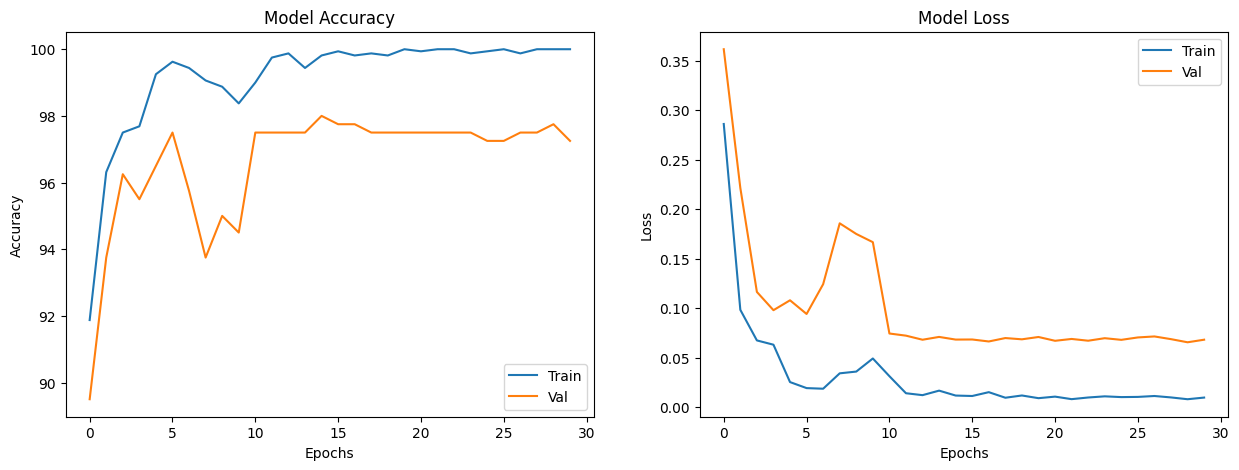

Test accuracy is 76.5%


In [30]:
model_ConvModel_V2_batch_normalization_a2 = ConvModel_V2(0.5, 1)
model_ConvModel_V2_batch_normalization_a2 = training(model=model_ConvModel_V2_batch_normalization_a2, epochs=30, weight_decay=0.01)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.0716, Train acc: 97.38%, Val loss: 0.6748, Val acc: 80.00%, Best Val loss: 0.6748 Best Val acc: 80.00%
Epoch 2/30, Train loss: 0.0324, Train acc: 98.94%, Val loss: 0.2093, Val acc: 95.75%, Best Val loss: 0.2093 Best Val acc: 95.75%
Epoch 3/30, Train loss: 0.0241, Train acc: 99.12%, Val loss: 0.4050, Val acc: 92.00%, Best Val loss: 0.2093 Best Val acc: 95.75%
Epoch 4/30, Train loss: 0.0402, Train acc: 98.62%, Val loss: 0.1426, Val acc: 95.75%, Best Val loss: 0.1426 Best Val acc: 95.75%
Epoch 5/30, Train loss: 0.0299, Train acc: 99.00%, Val loss: 0.1746, Val acc: 95.25%, Best Val loss: 0.1426 Best Val acc: 95.75%
Epoch 6/30, Train loss: 0.0507, Train acc: 98.12%, Val loss: 0.3140, Val acc: 92.25%, Best Val loss: 0.1426 Best Val acc: 95.75%
Epoch 7/30, Train loss: 0.0057, Train acc: 100.00%, Val loss: 0.0943, Val acc: 97.25%, Best Val loss: 0.0943 Best Val acc: 97.25%
Epoch 8/30, Train loss: 0.0144, Train acc: 99.38%, Val loss: 0.5122, Val acc: 91.00%, Best Val l

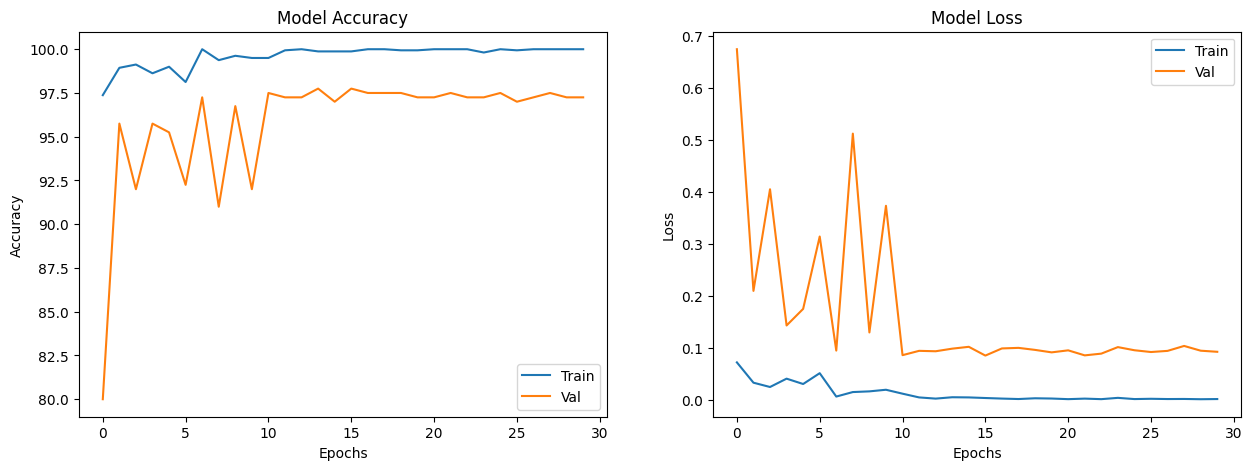

Test accuracy is 72.0%


In [55]:
model_ConvModel_V2_batch_normalization_a3 = ConvModel_V2(0.5, 1)
model_ConvModel_V2_batch_normalization_a3 = training(model=model_ConvModel_V2_batch_normalization_a2, epochs=30, weight_decay=0)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.1128, Train acc: 95.94%, Val loss: 0.4685, Val acc: 88.25%, Best Val loss: 0.4685 Best Val acc: 88.25%
Epoch 2/30, Train loss: 0.0565, Train acc: 98.06%, Val loss: 0.1107, Val acc: 96.75%, Best Val loss: 0.1107 Best Val acc: 96.75%
Epoch 3/30, Train loss: 0.0657, Train acc: 97.81%, Val loss: 1.4486, Val acc: 68.25%, Best Val loss: 0.1107 Best Val acc: 96.75%
Epoch 4/30, Train loss: 0.0211, Train acc: 99.25%, Val loss: 0.0820, Val acc: 96.75%, Best Val loss: 0.0820 Best Val acc: 96.75%
Epoch 5/30, Train loss: 0.0171, Train acc: 99.19%, Val loss: 0.0919, Val acc: 96.75%, Best Val loss: 0.0820 Best Val acc: 96.75%
Epoch 6/30, Train loss: 0.0269, Train acc: 98.88%, Val loss: 0.4849, Val acc: 88.25%, Best Val loss: 0.0820 Best Val acc: 96.75%
Epoch 7/30, Train loss: 0.0228, Train acc: 99.06%, Val loss: 0.0767, Val acc: 97.75%, Best Val loss: 0.0767 Best Val acc: 97.75%
Epoch 8/30, Train loss: 0.0161, Train acc: 99.38%, Val loss: 0.2171, Val acc: 95.50%, Best Val lo

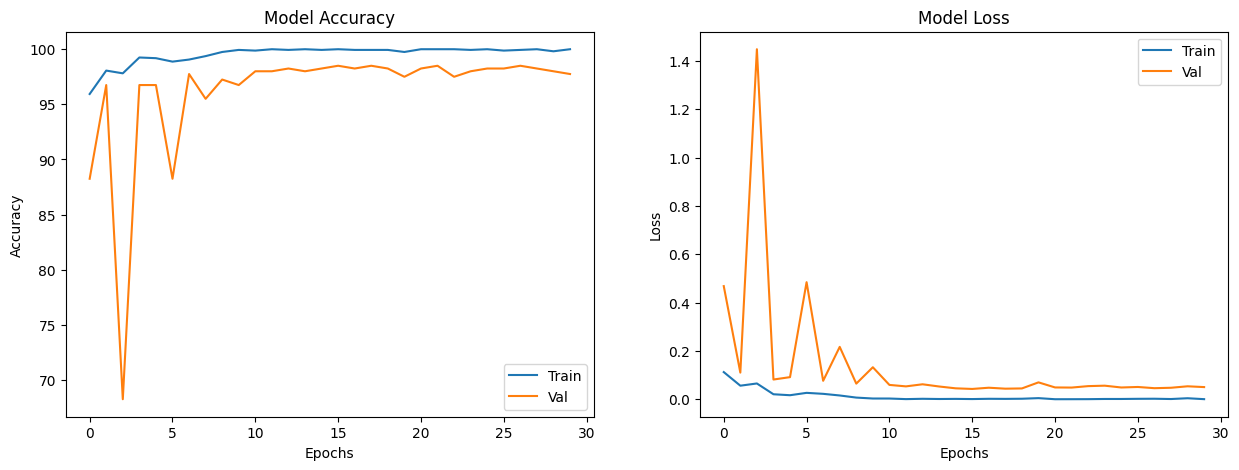

Test accuracy is 73.25%


In [246]:
model_ConvModel_V2_batch_normalization_a4 = ConvModel_V2(0, 0, simplify=True)
model_ConvModel_V2_batch_normalization_a4 = training(model=model_ConvModel_V2_batch_normalization_a2, epochs=30, weight_decay=0.0)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.0418, Train acc: 98.88%, Val loss: 0.2078, Val acc: 91.00%, Best Val loss: 0.2078 Best Val acc: 91.00%
Epoch 2/30, Train loss: 0.0548, Train acc: 98.19%, Val loss: 0.1304, Val acc: 96.25%, Best Val loss: 0.1304 Best Val acc: 96.25%
Epoch 3/30, Train loss: 0.0537, Train acc: 98.50%, Val loss: 0.1427, Val acc: 95.25%, Best Val loss: 0.1304 Best Val acc: 96.25%
Epoch 4/30, Train loss: 0.0402, Train acc: 99.00%, Val loss: 0.0725, Val acc: 96.75%, Best Val loss: 0.0725 Best Val acc: 96.75%
Epoch 5/30, Train loss: 0.0509, Train acc: 98.56%, Val loss: 0.0923, Val acc: 97.00%, Best Val loss: 0.0725 Best Val acc: 97.00%
Epoch 6/30, Train loss: 0.0399, Train acc: 99.06%, Val loss: 0.1755, Val acc: 94.25%, Best Val loss: 0.0725 Best Val acc: 97.00%
Epoch 7/30, Train loss: 0.0395, Train acc: 99.31%, Val loss: 0.2102, Val acc: 92.00%, Best Val loss: 0.0725 Best Val acc: 97.00%
Epoch 8/30, Train loss: 0.0720, Train acc: 97.44%, Val loss: 1.6670, Val acc: 51.25%, Best Val lo

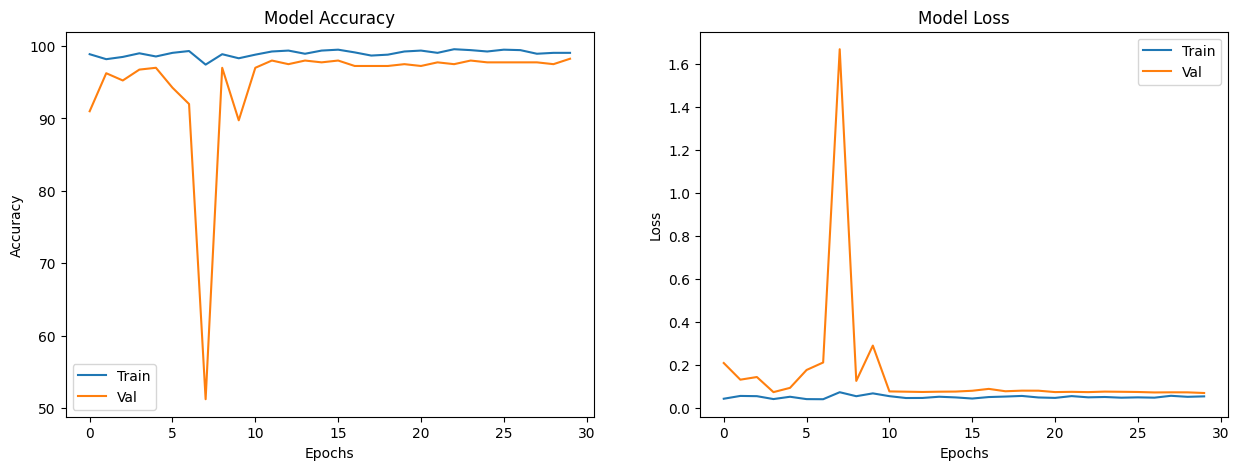

Test accuracy is 70.25%


In [253]:
model_ConvModel_V2_batch_normalization_a5 = ConvModel_V2(0.5, 1, simplify=True)
model_ConvModel_V2_batch_normalization_a5 = training(model=model_ConvModel_V2_batch_normalization_a2, epochs=30, weight_decay=0.01)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.0823, Train acc: 97.25%, Val loss: 0.1215, Val acc: 95.75%, Best Val loss: 0.1215 Best Val acc: 95.75%
Epoch 2/30, Train loss: 0.0815, Train acc: 97.62%, Val loss: 0.4045, Val acc: 82.25%, Best Val loss: 0.1215 Best Val acc: 95.75%
Epoch 3/30, Train loss: 0.0850, Train acc: 97.56%, Val loss: 1.5357, Val acc: 51.75%, Best Val loss: 0.1215 Best Val acc: 95.75%
Epoch 4/30, Train loss: 0.0679, Train acc: 98.50%, Val loss: 0.0989, Val acc: 95.25%, Best Val loss: 0.0989 Best Val acc: 95.75%
Epoch 5/30, Train loss: 0.0660, Train acc: 98.56%, Val loss: 0.4845, Val acc: 78.50%, Best Val loss: 0.0989 Best Val acc: 95.75%
Epoch 6/30, Train loss: 0.0653, Train acc: 98.25%, Val loss: 0.0862, Val acc: 98.00%, Best Val loss: 0.0862 Best Val acc: 98.00%
Epoch 7/30, Train loss: 0.0602, Train acc: 98.81%, Val loss: 0.1403, Val acc: 95.50%, Best Val loss: 0.0862 Best Val acc: 98.00%
Epoch 8/30, Train loss: 0.0716, Train acc: 98.00%, Val loss: 0.1369, Val acc: 95.25%, Best Val lo

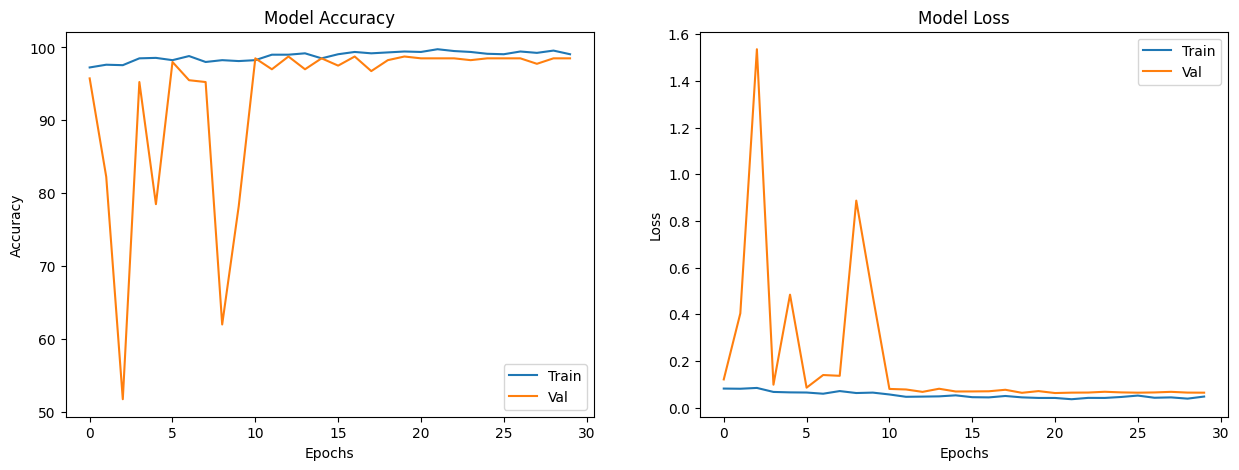

Test accuracy is 72.0%


In [255]:
model_ConvModel_V2_batch_normalization_a6 = ConvModel_V2(0.5, 1, simplify=True)
model_ConvModel_V2_batch_normalization_a6 = training(model=model_ConvModel_V2_batch_normalization_a2, 
                                                     epochs=30, weight_decay=0.01,
                                                    train_loader=train_loader_aug, val_loader=val_loader, test_loader=test_loader)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60, Train loss: 0.2083, Train acc: 93.38%, Val loss: 1.1518, Val acc: 69.75%, Best Val loss: 1.1518 Best Val acc: 69.75%
Epoch 2/60, Train loss: 0.1177, Train acc: 96.62%, Val loss: 0.1370, Val acc: 95.00%, Best Val loss: 0.1370 Best Val acc: 95.00%
Epoch 3/60, Train loss: 0.0832, Train acc: 96.94%, Val loss: 0.1603, Val acc: 95.50%, Best Val loss: 0.1370 Best Val acc: 95.50%
Epoch 4/60, Train loss: 0.0428, Train acc: 98.88%, Val loss: 0.1186, Val acc: 96.00%, Best Val loss: 0.1186 Best Val acc: 96.00%
Epoch 5/60, Train loss: 0.0258, Train acc: 99.12%, Val loss: 0.0637, Val acc: 98.25%, Best Val loss: 0.0637 Best Val acc: 98.25%
Epoch 6/60, Train loss: 0.0274, Train acc: 99.00%, Val loss: 0.1418, Val acc: 95.50%, Best Val loss: 0.0637 Best Val acc: 98.25%
Epoch 7/60, Train loss: 0.0343, Train acc: 99.06%, Val loss: 0.0894, Val acc: 97.50%, Best Val loss: 0.0637 Best Val acc: 98.25%
Epoch 8/60, Train loss: 0.0222, Train acc: 99.50%, Val loss: 0.0729, Val acc: 97.25%, Best Val lo

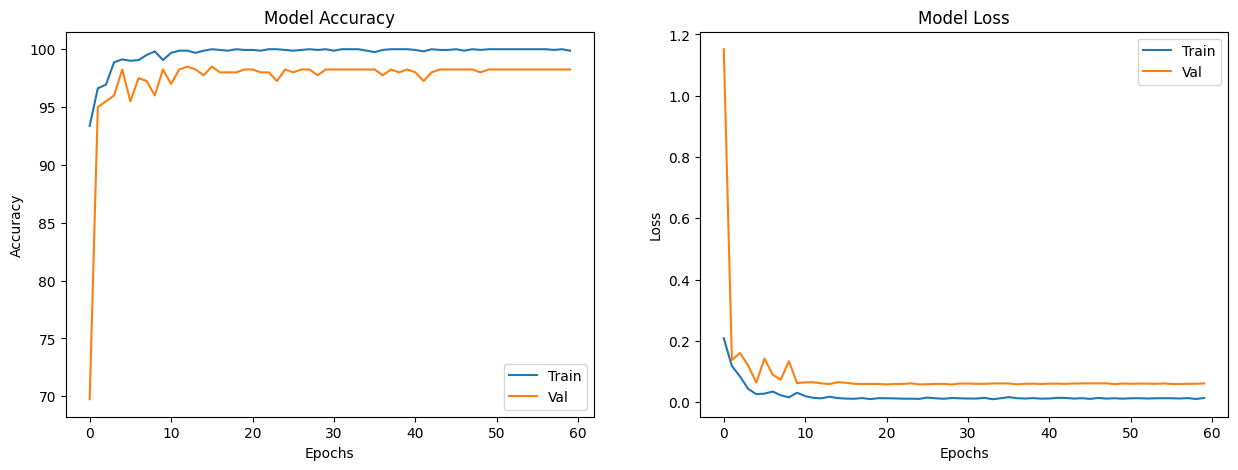

Test accuracy is 76.25%


In [259]:
model_ConvModel_V2_batch_normalization_a7 = ConvModel_V2(0.5, 1, simplify=True)
model_ConvModel_V2_batch_normalization_a7 = training(model=model_ConvModel_V2_batch_normalization_a7, 
                                                     epochs=60, weight_decay=0.01,
                                                    train_loader=train_loader_aug, val_loader=val_loader, test_loader=test_loader)

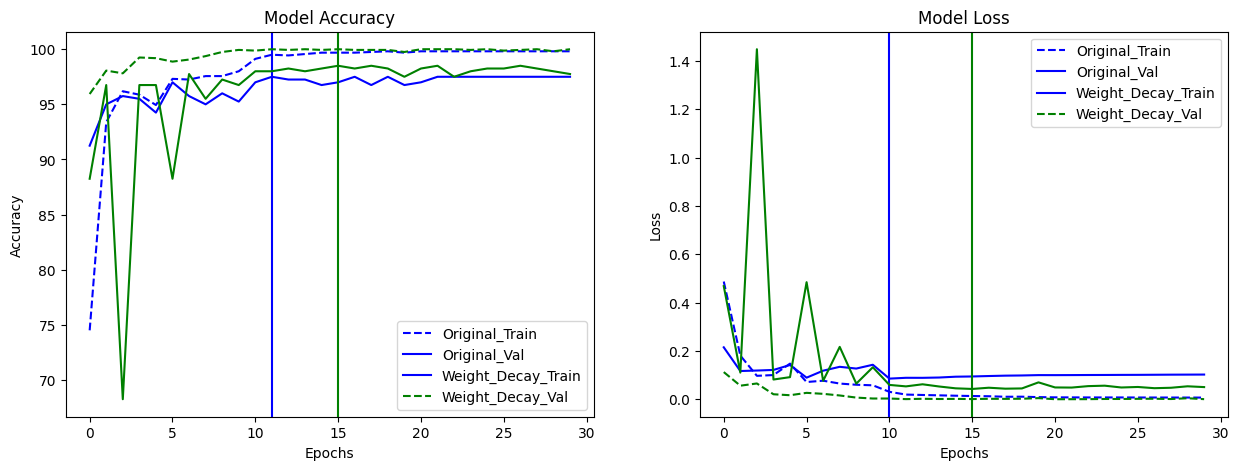

10.7 1.0568095255578205 test loss 
1.26%
15.5 1.8487995301527775 test loss 
1.70%


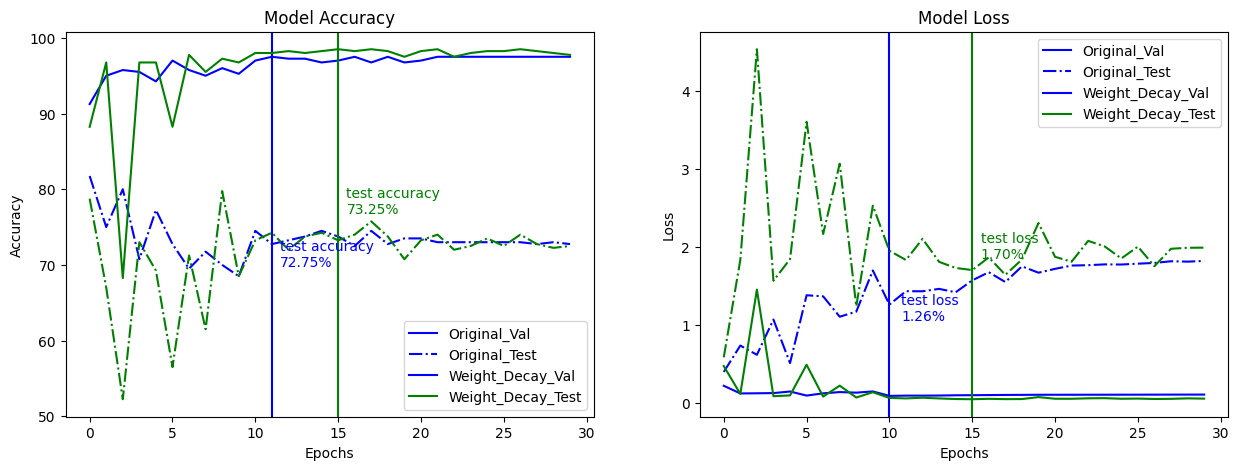

In [247]:
compare_learning_curve(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a4)
compare_generalization(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a4)

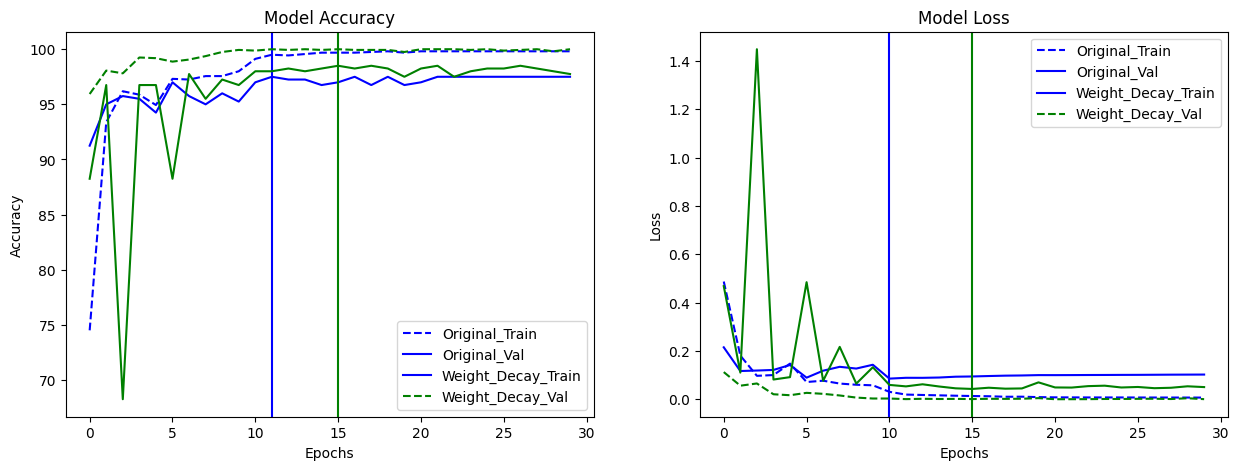

10.7 1.0568095255578205 test loss 
1.26%
15.5 1.8487995301527775 test loss 
1.70%


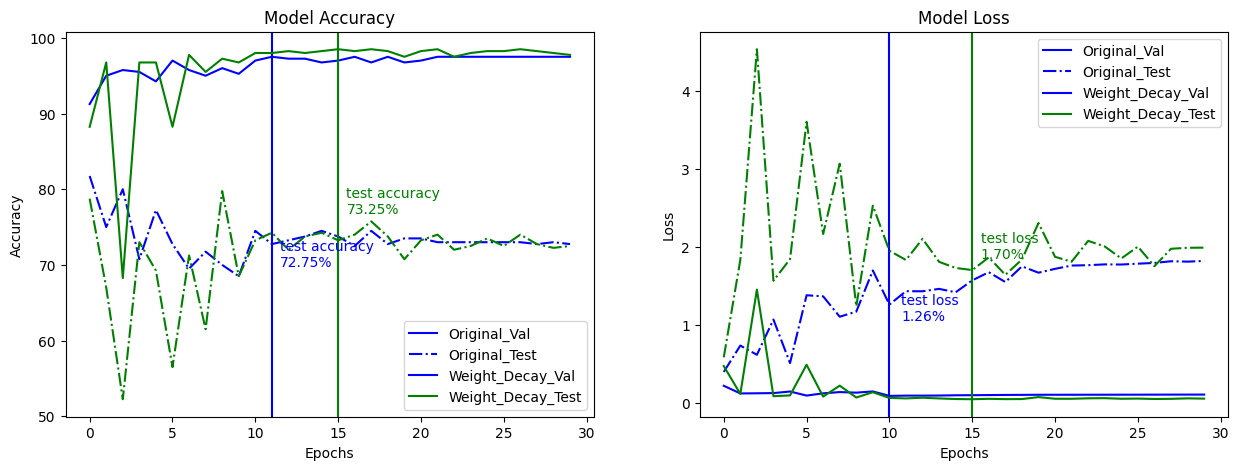

In [251]:
compare_learning_curve(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a4, 'reducing_model_complexity_2CNN')
compare_generalization(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a4, 'reducing_model_complexity_2CNN')

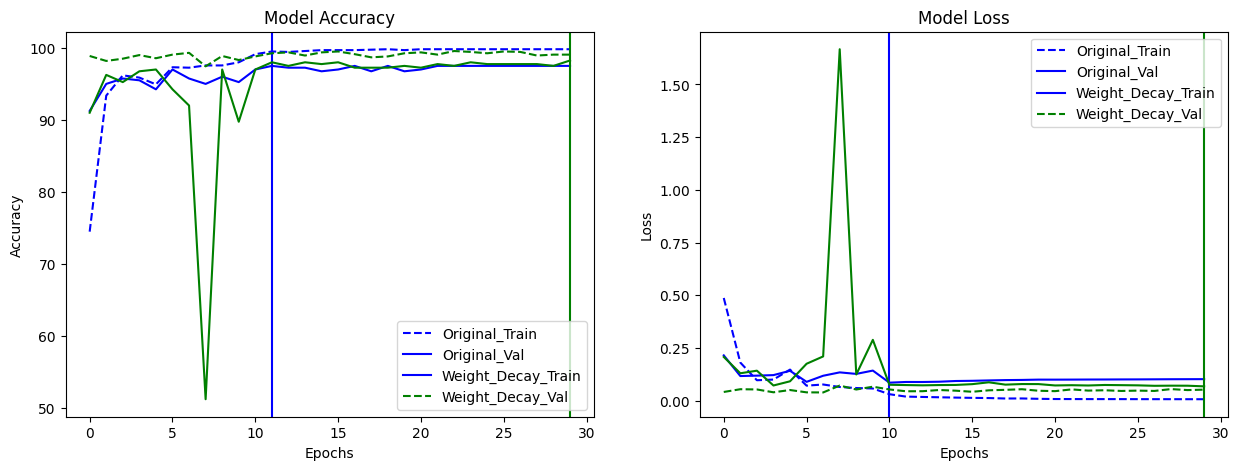

10.7 1.0568095255578205 test loss 
1.26%
29.5 0.8937184166449768 test loss 
0.74%


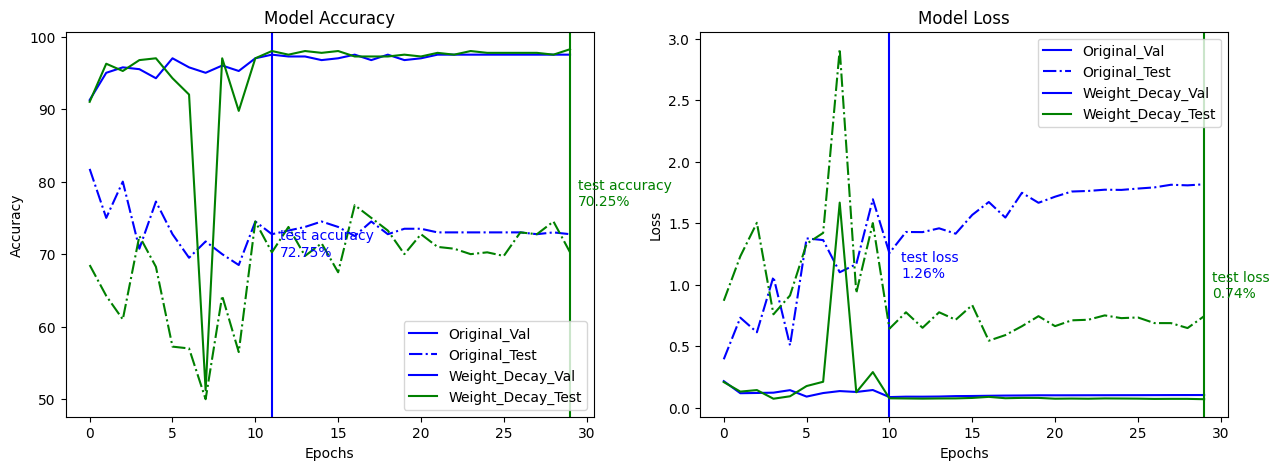

In [254]:
compare_learning_curve(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a5, 'D0_5__bn_T__wd_0_01__2CNN')
compare_generalization(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a5, 'D0_5__bn_T__wd_0_01__2CNN')

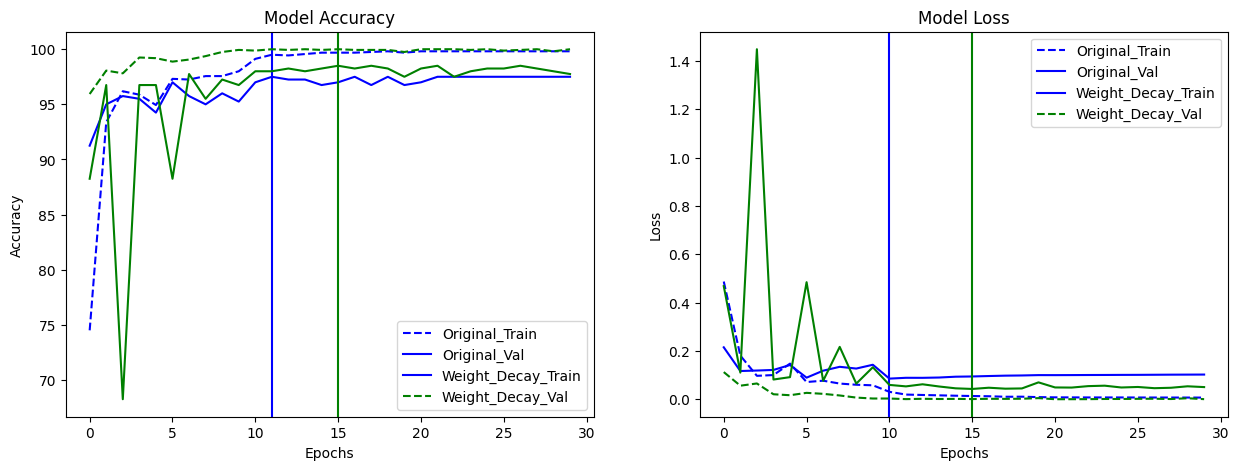

10.7 1.0568095255578205 test loss 
1.26%
15.5 1.8487995301527775 test loss 
1.70%


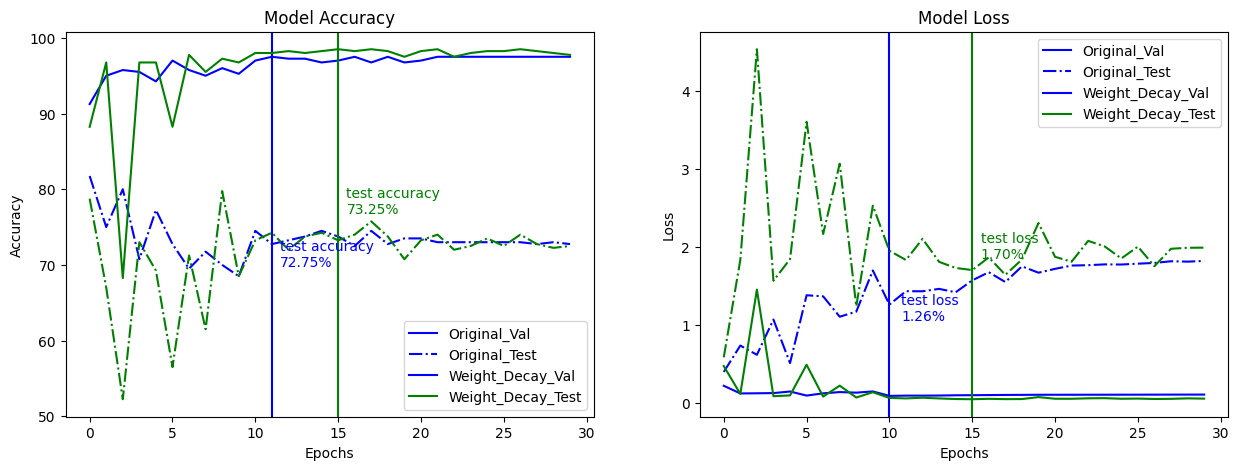

In [252]:
compare_learning_curve(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a4, 'reducing_model_complexity_2CNN')
compare_generalization(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a4, 'reducing_model_complexity_2CNN')

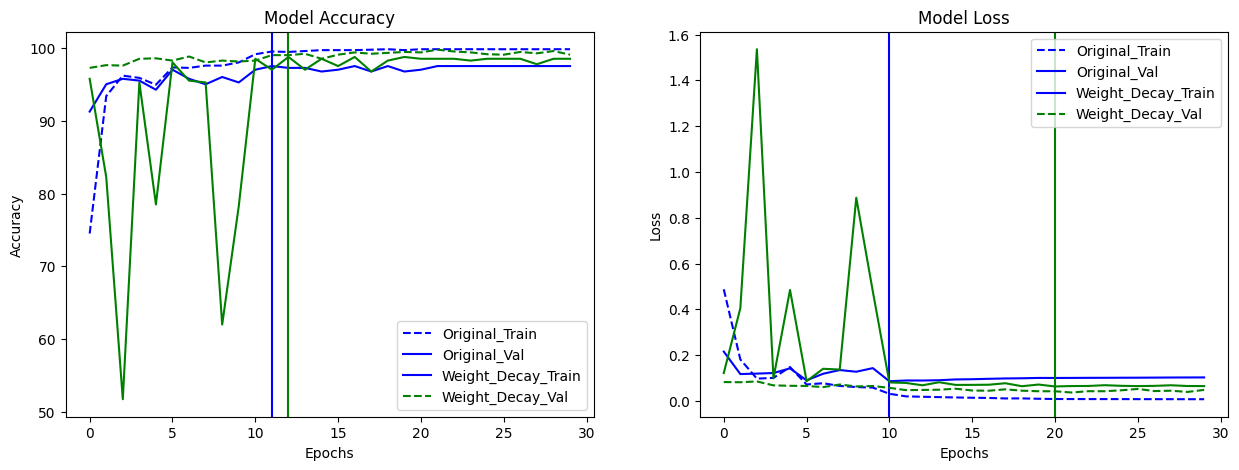

10.7 1.0568095255578205 test loss 
1.26%
20.5 0.8534484456078365 test loss 
0.70%


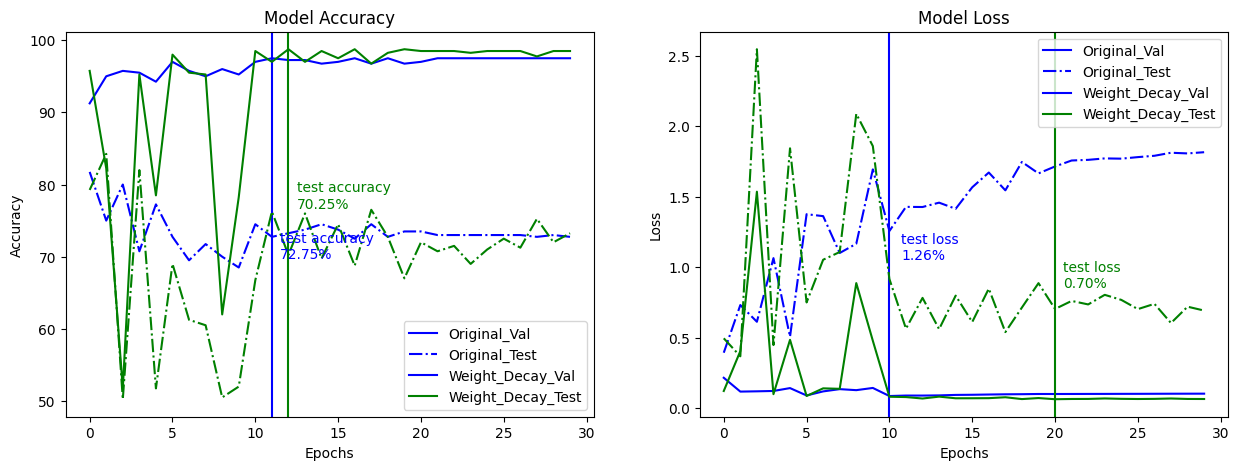

In [256]:
compare_learning_curve(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a6, 'D0_5__bn_T__wd_0_01__2CNN_aug')
compare_generalization(m_ConvModel_original_003, model_ConvModel_V2_batch_normalization_a6, 'D0_5__bn_T__wd_0_01__2CNN_aug')

In [36]:
def data_augment_transform(train_loader, val_loader, test_loader):
    
    # Define your data augmentation transforms
    data_transforms = transforms.Compose([
        # Add your desired data augmentation transforms here
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])

    # # ... (rest of your code)

    # # Create datasets with data augmentation
    # train_dataset = TensorDataset(x_train, y_train)
    # val_dataset = TensorDataset(x_val, y_val)

    # Create dataloaders with data augmentation for the training dataset
    # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Apply data augmentation transforms to the training dataset
    train_loader.dataset.transform = data_transforms
#     val_loader.dataset.transform = data_transforms
#     test_loader.dataset.transform = data_transforms
    
    return train_loader  # , val_loader, test_loader

In [37]:
train_loader_aug = data_augment_transform(train_loader, val_loader, test_loader)

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.3201, Train acc: 85.50%, Val loss: 0.2000, Val acc: 92.50%, Best Val loss: 0.2000 Best Val acc: 92.50%
Epoch 2/30, Train loss: 0.1316, Train acc: 95.88%, Val loss: 0.1072, Val acc: 95.75%, Best Val loss: 0.1072 Best Val acc: 95.75%
Epoch 3/30, Train loss: 0.0920, Train acc: 96.56%, Val loss: 0.1076, Val acc: 95.75%, Best Val loss: 0.1072 Best Val acc: 95.75%
Epoch 4/30, Train loss: 0.0926, Train acc: 96.81%, Val loss: 0.1054, Val acc: 95.75%, Best Val loss: 0.1054 Best Val acc: 95.75%
Epoch 5/30, Train loss: 0.0726, Train acc: 97.69%, Val loss: 0.1458, Val acc: 94.00%, Best Val loss: 0.1054 Best Val acc: 95.75%
Epoch 6/30, Train loss: 0.0465, Train acc: 98.25%, Val loss: 0.1004, Val acc: 96.25%, Best Val loss: 0.1004 Best Val acc: 96.25%
Epoch 7/30, Train loss: 0.0887, Train acc: 96.56%, Val loss: 0.1188, Val acc: 95.25%, Best Val loss: 0.1004 Best Val acc: 96.25%
Epoch 8/30, Train loss: 0.0989, Train acc: 96.69%, Val loss: 0.1665, Val acc: 93.75%, Best Val lo

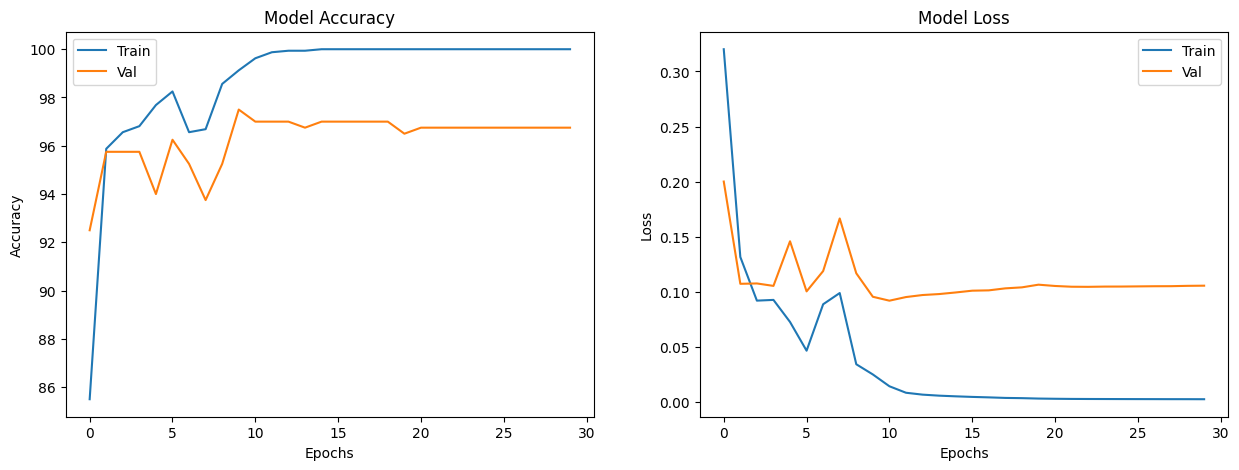

Test accuracy is 75.75%
ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.0533, Train acc: 98.69%, Val loss: 0.2067, Val acc: 95.25%, Best Val loss: 0.2067 Best Val acc: 95.25%
Epoch 2/30, Train loss: 0.0394, Train acc: 98.62%, Val loss: 0.2778, Val acc: 96.75%, Best Val loss: 0.2067 Best Val acc: 96.75%
Epoch 3/30, Train loss: 0.0456, Train acc: 98.81%, Val loss: 0.2661, Val acc: 95.25%, Best Val loss: 0.2067 Best Val acc: 96.75%
Epoch 4/30, Train loss: 0.0370, Train acc: 99.19%, Val loss: 0.3211, Val acc: 94.50%, Best Val loss: 0.2067 Best Val acc: 96.75%
Epoch 5/30, Train loss: 0.0376, Train acc: 99.00%, Val loss: 1.9216, Val acc: 84.50%, Best Val loss: 0.2067 Best Val acc: 96.75%
Epoch 6/30, Train loss: 0.0259, Train acc: 99.38%, Val loss: 0.2343, Val acc: 96.00%, Best Val loss: 0.2067 Best Val acc: 96.75%
Epoch 7/30, Train loss: 0.0439, Train acc: 99.12%, Val loss: 0.2473, Val acc: 96.75%, Best Val loss: 0.2067 Best Val acc: 96.75%
Epoch 8/30, Train loss: 0.0382, Train acc: 99.19%, Val loss: 0.3004, Val acc: 94.25%, Best Val lo

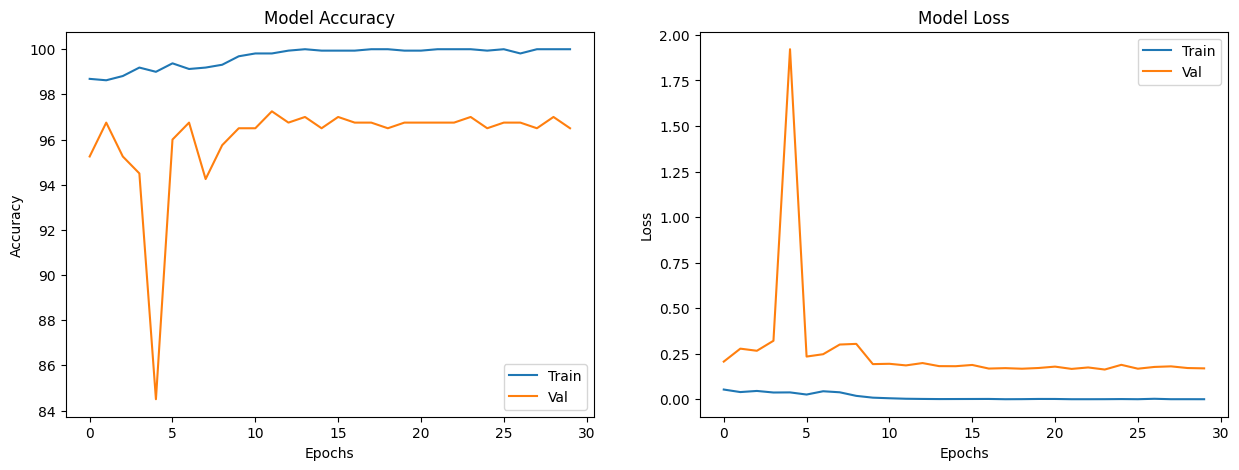

Test accuracy is 72.5%


ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

In [38]:
model_ConvModel_V2_aug_1 = ConvModel_V2(0, False)
model_ConvModel_V2_aug_1 = training(model=model_ConvModel_V2_aug_1, epochs=30, weight_decay=0, 
             train_loader=train_loader_aug, val_loader=val_loader, test_loader=test_loader)

In [53]:
def data_augment_transform_comb(X_train, Y_train):
    
    # Define your data augmentation transforms
    data_transforms = transforms.Compose([
        # Add your desired data augmentation transforms here
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
        transforms.ToTensor(),
    ])

    # # ... (rest of your code)

    # # Create datasets with data augmentation
    original_train_dataset = TensorDataset(x_train, y_train)
    augmented_train_dataset = TensorDataset(x_train, y_train)
    augmented_train_dataset.transform = data_transforms  # Apply data augmentation to the augmented dataset

    # Combine both datasets into a single dataset
    combined_dataset = ConcatDataset([original_train_dataset, augmented_train_dataset])

    # Create a data loader from the combined dataset
    combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

    
    return combined_loader

ConvModel_V2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (bn4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Train loss: 0.2661, Train acc: 88.12%, Val loss: 0.1193, Val acc: 96.25%, Best Val loss: 0.1193 Best Val acc: 96.25%
Epoch 2/5, Train loss: 0.1059, Train acc: 96.12%, Val loss: 0.1075, Val acc: 96.50%, Best Val loss: 0.1075 Best Val acc: 96.50%
Epoch 3/5, Train loss: 0.0643, Train acc: 97.59%, Val loss: 0.1005, Val acc: 96.50%, Best Val loss: 0.1005 Best Val acc: 96.50%
Epoch 4/5, Train loss: 0.0419, Train acc: 98.44%, Val loss: 0.0928, Val acc: 96.50%, Best Val loss: 0.0928 Best Val acc: 96.50%
Epoch 5/5, Train loss: 0.0346, Train acc: 98.78%, Val loss: 0.1729, Val acc: 94.50%, Best Val loss: 0.0928 Best Val acc: 96.50%


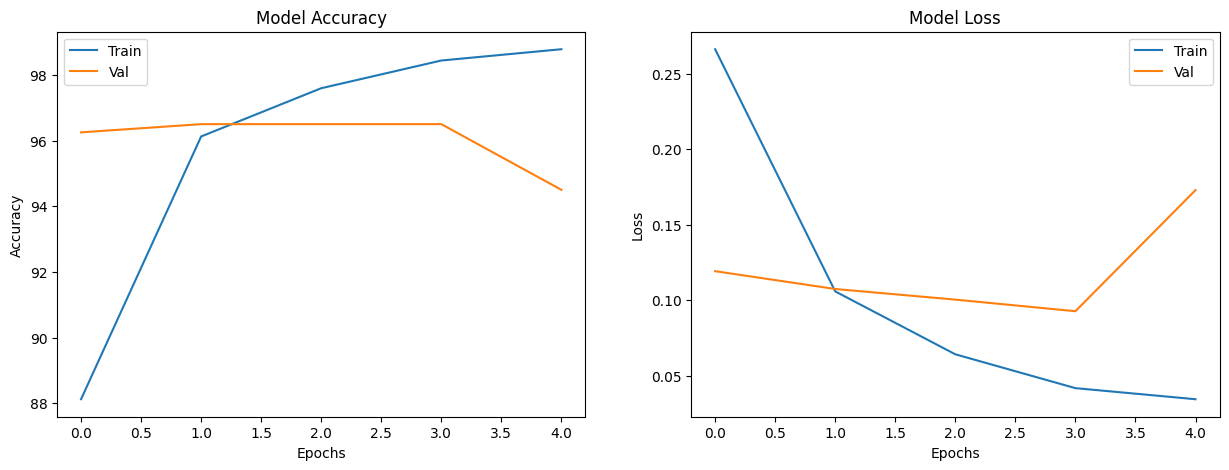

Test accuracy is 79.0%


In [54]:
train_loader_aug_comb = data_augment_transform_comb(x_train, y_train)
model_ConvModel_V2_aug_2 = ConvModel_V2(0, False)
model_ConvModel_V2_aug_2 = training(model=model_ConvModel_V2_aug_2, epochs=5, weight_decay=0, 
             train_loader=train_loader_aug_comb, val_loader=val_loader, test_loader=test_loader)

ConvGAP(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=32, out_features=1, bias=True)
  )
)


  3%|██▊                                                                                | 1/30 [00:02<01:18,  2.70s/it]

Epoch 1/30, Train loss: 0.6955, Train acc: 50.00%, Val loss: 0.6914, Val acc: 50.00%, Best Val loss: 0.6914 Best Val acc: 50.00%


  7%|█████▌                                                                             | 2/30 [00:05<01:12,  2.58s/it]

Epoch 2/30, Train loss: 0.6877, Train acc: 54.94%, Val loss: 0.6658, Val acc: 69.75%, Best Val loss: 0.6658 Best Val acc: 69.75%


 10%|████████▎                                                                          | 3/30 [00:07<01:03,  2.36s/it]

Epoch 3/30, Train loss: 0.6647, Train acc: 62.94%, Val loss: 0.6265, Val acc: 68.75%, Best Val loss: 0.6265 Best Val acc: 69.75%


 13%|███████████                                                                        | 4/30 [00:09<00:56,  2.19s/it]

Epoch 4/30, Train loss: 0.6444, Train acc: 66.12%, Val loss: 0.6203, Val acc: 66.00%, Best Val loss: 0.6203 Best Val acc: 69.75%


 17%|█████████████▊                                                                     | 5/30 [00:11<00:52,  2.10s/it]

Epoch 5/30, Train loss: 0.6345, Train acc: 66.19%, Val loss: 0.5960, Val acc: 71.75%, Best Val loss: 0.5960 Best Val acc: 71.75%


 20%|████████████████▌                                                                  | 6/30 [00:13<00:52,  2.18s/it]

Epoch 6/30, Train loss: 0.6168, Train acc: 68.44%, Val loss: 0.5819, Val acc: 75.25%, Best Val loss: 0.5819 Best Val acc: 75.25%


 23%|███████████████████▎                                                               | 7/30 [00:15<00:52,  2.26s/it]

Epoch 7/30, Train loss: 0.5968, Train acc: 70.94%, Val loss: 0.5603, Val acc: 75.25%, Best Val loss: 0.5603 Best Val acc: 75.25%


 27%|██████████████████████▏                                                            | 8/30 [00:18<00:49,  2.27s/it]

Epoch 8/30, Train loss: 0.5755, Train acc: 72.88%, Val loss: 0.5379, Val acc: 76.75%, Best Val loss: 0.5379 Best Val acc: 76.75%


 30%|████████████████████████▉                                                          | 9/30 [00:20<00:46,  2.22s/it]

Epoch 9/30, Train loss: 0.5458, Train acc: 75.25%, Val loss: 0.5247, Val acc: 79.00%, Best Val loss: 0.5247 Best Val acc: 79.00%


 33%|███████████████████████████▎                                                      | 10/30 [00:22<00:45,  2.25s/it]

Epoch 10/30, Train loss: 0.5118, Train acc: 78.50%, Val loss: 0.4624, Val acc: 81.25%, Best Val loss: 0.4624 Best Val acc: 81.25%


 37%|██████████████████████████████                                                    | 11/30 [00:25<00:43,  2.31s/it]

Epoch 11/30, Train loss: 0.4737, Train acc: 80.81%, Val loss: 0.4487, Val acc: 83.75%, Best Val loss: 0.4487 Best Val acc: 83.75%


 40%|████████████████████████████████▊                                                 | 12/30 [00:27<00:42,  2.38s/it]

Epoch 12/30, Train loss: 0.4581, Train acc: 82.12%, Val loss: 0.4366, Val acc: 82.50%, Best Val loss: 0.4366 Best Val acc: 83.75%


 43%|███████████████████████████████████▌                                              | 13/30 [00:30<00:41,  2.43s/it]

Epoch 13/30, Train loss: 0.4516, Train acc: 82.00%, Val loss: 0.4286, Val acc: 84.00%, Best Val loss: 0.4286 Best Val acc: 84.00%


 47%|██████████████████████████████████████▎                                           | 14/30 [00:32<00:37,  2.33s/it]

Epoch 14/30, Train loss: 0.4425, Train acc: 82.12%, Val loss: 0.4241, Val acc: 83.75%, Best Val loss: 0.4241 Best Val acc: 84.00%


 50%|█████████████████████████████████████████                                         | 15/30 [00:34<00:34,  2.27s/it]

Epoch 15/30, Train loss: 0.4375, Train acc: 82.69%, Val loss: 0.4258, Val acc: 85.25%, Best Val loss: 0.4241 Best Val acc: 85.25%


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:37<00:34,  2.44s/it]

Epoch 16/30, Train loss: 0.4390, Train acc: 83.19%, Val loss: 0.4175, Val acc: 83.00%, Best Val loss: 0.4175 Best Val acc: 85.25%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:39<00:31,  2.44s/it]

Epoch 17/30, Train loss: 0.4304, Train acc: 83.50%, Val loss: 0.4091, Val acc: 84.75%, Best Val loss: 0.4091 Best Val acc: 85.25%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:42<00:29,  2.50s/it]

Epoch 18/30, Train loss: 0.4267, Train acc: 84.06%, Val loss: 0.4108, Val acc: 86.75%, Best Val loss: 0.4091 Best Val acc: 86.75%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:44<00:27,  2.51s/it]

Epoch 19/30, Train loss: 0.4189, Train acc: 84.38%, Val loss: 0.3992, Val acc: 85.75%, Best Val loss: 0.3992 Best Val acc: 86.75%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:47<00:25,  2.54s/it]

Epoch 20/30, Train loss: 0.4123, Train acc: 84.62%, Val loss: 0.3912, Val acc: 85.25%, Best Val loss: 0.3912 Best Val acc: 86.75%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:50<00:22,  2.55s/it]

Epoch 21/30, Train loss: 0.4075, Train acc: 85.06%, Val loss: 0.3911, Val acc: 85.25%, Best Val loss: 0.3911 Best Val acc: 86.75%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:52<00:20,  2.57s/it]

Epoch 22/30, Train loss: 0.4070, Train acc: 85.25%, Val loss: 0.3902, Val acc: 85.25%, Best Val loss: 0.3902 Best Val acc: 86.75%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:54<00:17,  2.50s/it]

Epoch 23/30, Train loss: 0.4067, Train acc: 85.12%, Val loss: 0.3900, Val acc: 85.50%, Best Val loss: 0.3900 Best Val acc: 86.75%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:57<00:14,  2.40s/it]

Epoch 24/30, Train loss: 0.4063, Train acc: 85.06%, Val loss: 0.3895, Val acc: 85.50%, Best Val loss: 0.3895 Best Val acc: 86.75%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:59<00:11,  2.32s/it]

Epoch 25/30, Train loss: 0.4057, Train acc: 85.19%, Val loss: 0.3890, Val acc: 85.50%, Best Val loss: 0.3890 Best Val acc: 86.75%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [01:01<00:09,  2.43s/it]

Epoch 26/30, Train loss: 0.4051, Train acc: 85.31%, Val loss: 0.3889, Val acc: 85.75%, Best Val loss: 0.3889 Best Val acc: 86.75%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [01:04<00:07,  2.47s/it]

Epoch 27/30, Train loss: 0.4050, Train acc: 85.25%, Val loss: 0.3881, Val acc: 85.50%, Best Val loss: 0.3881 Best Val acc: 86.75%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [01:07<00:05,  2.62s/it]

Epoch 28/30, Train loss: 0.4045, Train acc: 85.19%, Val loss: 0.3877, Val acc: 85.50%, Best Val loss: 0.3877 Best Val acc: 86.75%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [01:10<00:02,  2.66s/it]

Epoch 29/30, Train loss: 0.4040, Train acc: 85.19%, Val loss: 0.3876, Val acc: 85.75%, Best Val loss: 0.3876 Best Val acc: 86.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:13<00:00,  2.43s/it]

Epoch 30/30, Train loss: 0.4035, Train acc: 85.19%, Val loss: 0.3874, Val acc: 86.00%, Best Val loss: 0.3874 Best Val acc: 86.75%


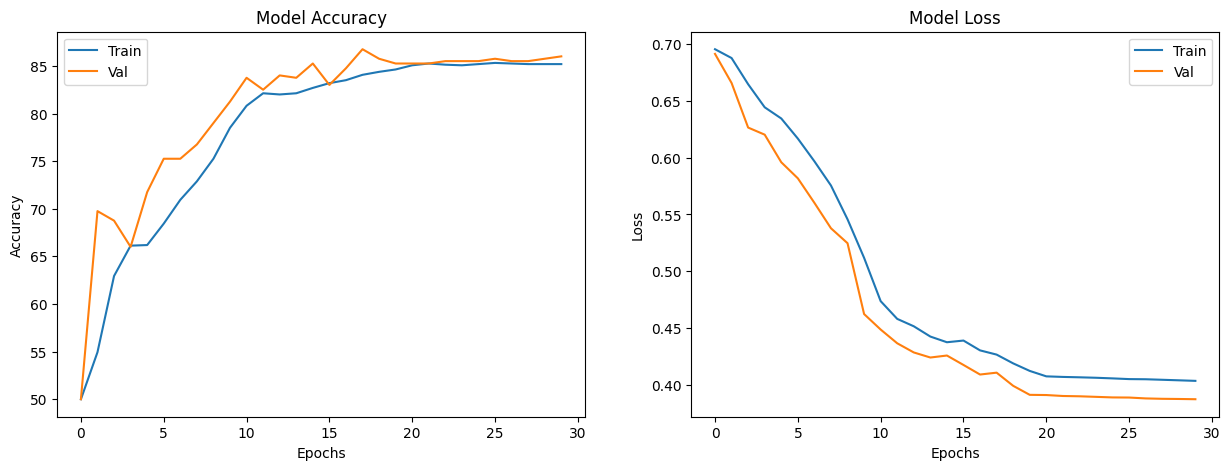

Test accuracy is 69.75%


In [63]:
# Original ConvModel

model_ConvGAP = ConvGAP()

m_ConvGAP_original = training(model=model_ConvGAP, epochs=30, serial_no='model_ConvGAP_001')

In [66]:
class ConvGAP_V2(nn.Module):
    def __init__(self, channel=32):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same') ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128*128
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 128*128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*64
            nn.Conv2d(32, channel, kernel_size=3, stride=1, padding='same'), # 64*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*32

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channel, 1)
        )

    def forward(self, x):

        x = self.net(x)
        return x

ConvGAP_V2(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 1204, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=1)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1204, out_features=1, bias=True)
  )
)


  3%|██▊                                                                                | 1/30 [00:06<03:06,  6.43s/it]

Epoch 1/30, Train loss: 0.6933, Train acc: 52.56%, Val loss: 0.6848, Val acc: 52.25%, Best Val loss: 0.6848 Best Val acc: 52.25%


  7%|█████▌                                                                             | 2/30 [00:12<02:52,  6.18s/it]

Epoch 2/30, Train loss: 0.6703, Train acc: 63.62%, Val loss: 0.6235, Val acc: 70.25%, Best Val loss: 0.6235 Best Val acc: 70.25%


 10%|████████▎                                                                          | 3/30 [00:18<02:44,  6.10s/it]

Epoch 3/30, Train loss: 0.6026, Train acc: 69.19%, Val loss: 0.5480, Val acc: 71.00%, Best Val loss: 0.5480 Best Val acc: 71.00%


 13%|███████████                                                                        | 4/30 [00:24<02:39,  6.13s/it]

Epoch 4/30, Train loss: 0.5626, Train acc: 71.56%, Val loss: 0.4763, Val acc: 80.00%, Best Val loss: 0.4763 Best Val acc: 80.00%


 17%|█████████████▊                                                                     | 5/30 [00:30<02:34,  6.16s/it]

Epoch 5/30, Train loss: 0.5005, Train acc: 77.69%, Val loss: 0.4840, Val acc: 79.25%, Best Val loss: 0.4763 Best Val acc: 80.00%


 20%|████████████████▌                                                                  | 6/30 [00:36<02:27,  6.16s/it]

Epoch 6/30, Train loss: 0.4750, Train acc: 79.50%, Val loss: 0.3954, Val acc: 85.50%, Best Val loss: 0.3954 Best Val acc: 85.50%


 23%|███████████████████▎                                                               | 7/30 [00:43<02:21,  6.15s/it]

Epoch 7/30, Train loss: 0.3986, Train acc: 84.38%, Val loss: 0.3447, Val acc: 89.75%, Best Val loss: 0.3447 Best Val acc: 89.75%


 27%|██████████████████████▏                                                            | 8/30 [00:48<02:11,  5.99s/it]

Epoch 8/30, Train loss: 0.3979, Train acc: 83.44%, Val loss: 0.3473, Val acc: 88.00%, Best Val loss: 0.3447 Best Val acc: 89.75%


 30%|████████████████████████▉                                                          | 9/30 [00:54<02:05,  5.97s/it]

Epoch 9/30, Train loss: 0.3900, Train acc: 84.44%, Val loss: 0.3095, Val acc: 90.00%, Best Val loss: 0.3095 Best Val acc: 90.00%


 33%|███████████████████████████▎                                                      | 10/30 [01:00<01:59,  5.96s/it]

Epoch 10/30, Train loss: 0.3109, Train acc: 89.44%, Val loss: 0.3012, Val acc: 89.00%, Best Val loss: 0.3012 Best Val acc: 90.00%


 37%|██████████████████████████████                                                    | 11/30 [01:06<01:51,  5.88s/it]

Epoch 11/30, Train loss: 0.2861, Train acc: 89.56%, Val loss: 0.2649, Val acc: 91.25%, Best Val loss: 0.2649 Best Val acc: 91.25%


 40%|████████████████████████████████▊                                                 | 12/30 [01:11<01:43,  5.77s/it]

Epoch 12/30, Train loss: 0.2818, Train acc: 89.69%, Val loss: 0.2718, Val acc: 91.00%, Best Val loss: 0.2649 Best Val acc: 91.25%


 43%|███████████████████████████████████▌                                              | 13/30 [01:17<01:39,  5.84s/it]

Epoch 13/30, Train loss: 0.2777, Train acc: 89.81%, Val loss: 0.2598, Val acc: 91.50%, Best Val loss: 0.2598 Best Val acc: 91.50%


 47%|██████████████████████████████████████▎                                           | 14/30 [01:23<01:33,  5.86s/it]

Epoch 14/30, Train loss: 0.2728, Train acc: 89.94%, Val loss: 0.2563, Val acc: 91.75%, Best Val loss: 0.2563 Best Val acc: 91.75%


 50%|█████████████████████████████████████████                                         | 15/30 [01:28<01:25,  5.68s/it]

Epoch 15/30, Train loss: 0.2728, Train acc: 90.06%, Val loss: 0.2547, Val acc: 91.75%, Best Val loss: 0.2547 Best Val acc: 91.75%


 53%|███████████████████████████████████████████▋                                      | 16/30 [01:34<01:17,  5.57s/it]

Epoch 16/30, Train loss: 0.2681, Train acc: 90.00%, Val loss: 0.2562, Val acc: 90.75%, Best Val loss: 0.2547 Best Val acc: 91.75%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [01:39<01:11,  5.51s/it]

Epoch 17/30, Train loss: 0.2654, Train acc: 90.56%, Val loss: 0.2540, Val acc: 91.00%, Best Val loss: 0.2540 Best Val acc: 91.75%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:07<02:24, 12.07s/it]

Epoch 18/30, Train loss: 0.2666, Train acc: 90.56%, Val loss: 0.2490, Val acc: 92.25%, Best Val loss: 0.2490 Best Val acc: 92.25%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:46<03:42, 20.21s/it]

Epoch 19/30, Train loss: 0.2605, Train acc: 90.50%, Val loss: 0.2478, Val acc: 91.50%, Best Val loss: 0.2478 Best Val acc: 92.25%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [03:23<04:14, 25.42s/it]

Epoch 20/30, Train loss: 0.2585, Train acc: 90.75%, Val loss: 0.2456, Val acc: 91.75%, Best Val loss: 0.2456 Best Val acc: 92.25%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [04:00<04:20, 28.95s/it]

Epoch 21/30, Train loss: 0.2546, Train acc: 91.00%, Val loss: 0.2457, Val acc: 91.75%, Best Val loss: 0.2456 Best Val acc: 92.25%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [04:38<04:12, 31.51s/it]

Epoch 22/30, Train loss: 0.2541, Train acc: 91.12%, Val loss: 0.2461, Val acc: 91.75%, Best Val loss: 0.2456 Best Val acc: 92.25%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [05:14<03:49, 32.83s/it]

Epoch 23/30, Train loss: 0.2538, Train acc: 90.88%, Val loss: 0.2464, Val acc: 91.50%, Best Val loss: 0.2456 Best Val acc: 92.25%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [05:50<03:22, 33.75s/it]

Epoch 24/30, Train loss: 0.2541, Train acc: 91.00%, Val loss: 0.2467, Val acc: 91.50%, Best Val loss: 0.2456 Best Val acc: 92.25%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [06:26<02:52, 34.56s/it]

Epoch 25/30, Train loss: 0.2536, Train acc: 91.12%, Val loss: 0.2457, Val acc: 91.75%, Best Val loss: 0.2456 Best Val acc: 92.25%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [07:02<02:20, 35.07s/it]

Epoch 26/30, Train loss: 0.2532, Train acc: 91.12%, Val loss: 0.2461, Val acc: 91.50%, Best Val loss: 0.2456 Best Val acc: 92.25%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [07:38<01:45, 35.13s/it]

Epoch 27/30, Train loss: 0.2529, Train acc: 91.00%, Val loss: 0.2451, Val acc: 91.75%, Best Val loss: 0.2451 Best Val acc: 92.25%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [08:13<01:10, 35.12s/it]

Epoch 28/30, Train loss: 0.2523, Train acc: 91.12%, Val loss: 0.2447, Val acc: 91.75%, Best Val loss: 0.2447 Best Val acc: 92.25%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [08:49<00:35, 35.54s/it]

Epoch 29/30, Train loss: 0.2521, Train acc: 91.06%, Val loss: 0.2447, Val acc: 91.75%, Best Val loss: 0.2447 Best Val acc: 92.25%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [09:26<00:00, 18.88s/it]

Epoch 30/30, Train loss: 0.2519, Train acc: 91.25%, Val loss: 0.2446, Val acc: 91.75%, Best Val loss: 0.2446 Best Val acc: 92.25%


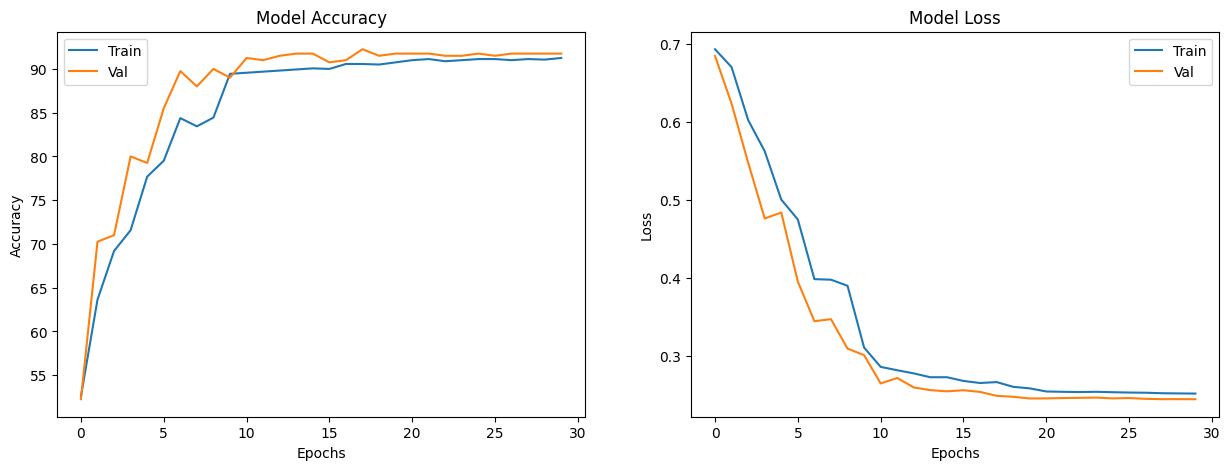

Test accuracy is 75.25%


In [68]:
# Original ConvModel

model_ConvGAP_V2_1024 = ConvGAP_V2(channel=1204)

m_ConvGAP_V2_1024 = training(model=model_ConvGAP_V2_1024, epochs=30, serial_no='model_ConvGAP_channel_1024_002')

In [26]:
# torch.cuda.empty_cache()


In [46]:
model_ConvModel = ConvModel()
model_LinearModel = LinearModel()

def training_time(model):
    start_time = time.time()
    m_ = training(model=model, epochs=30)
    end_time = time.time()
    return end_time - start_time, m_

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  3%|██▊                                                                                | 1/30 [00:03<01:28,  3.04s/it]

Epoch 1/30, Train loss: 0.5393, Train acc: 68.88%, Val loss: 0.2770, Val acc: 89.25%, Best Val loss: 0.2770 Best Val acc: 89.25%


  7%|█████▌                                                                             | 2/30 [00:05<01:20,  2.88s/it]

Epoch 2/30, Train loss: 0.1959, Train acc: 92.62%, Val loss: 0.1498, Val acc: 94.00%, Best Val loss: 0.1498 Best Val acc: 94.00%


 10%|████████▎                                                                          | 3/30 [00:08<01:20,  3.00s/it]

Epoch 3/30, Train loss: 0.1399, Train acc: 95.12%, Val loss: 0.1368, Val acc: 94.50%, Best Val loss: 0.1368 Best Val acc: 94.50%


 13%|███████████                                                                        | 4/30 [00:11<01:15,  2.91s/it]

Epoch 4/30, Train loss: 0.0880, Train acc: 97.25%, Val loss: 0.1282, Val acc: 94.50%, Best Val loss: 0.1282 Best Val acc: 94.50%


 17%|█████████████▊                                                                     | 5/30 [00:14<01:08,  2.74s/it]

Epoch 5/30, Train loss: 0.0737, Train acc: 97.12%, Val loss: 0.1111, Val acc: 95.00%, Best Val loss: 0.1111 Best Val acc: 95.00%


 20%|████████████████▌                                                                  | 6/30 [00:16<01:02,  2.62s/it]

Epoch 6/30, Train loss: 0.0660, Train acc: 97.19%, Val loss: 0.1363, Val acc: 95.25%, Best Val loss: 0.1111 Best Val acc: 95.25%


 23%|███████████████████▎                                                               | 7/30 [00:19<01:00,  2.62s/it]

Epoch 7/30, Train loss: 0.0910, Train acc: 96.81%, Val loss: 0.1109, Val acc: 95.25%, Best Val loss: 0.1109 Best Val acc: 95.25%


 27%|██████████████████████▏                                                            | 8/30 [00:22<00:59,  2.72s/it]

Epoch 8/30, Train loss: 0.0495, Train acc: 98.50%, Val loss: 0.1033, Val acc: 95.75%, Best Val loss: 0.1033 Best Val acc: 95.75%


 30%|████████████████████████▉                                                          | 9/30 [00:24<00:55,  2.64s/it]

Epoch 9/30, Train loss: 0.0526, Train acc: 97.94%, Val loss: 0.1152, Val acc: 96.00%, Best Val loss: 0.1033 Best Val acc: 96.00%


 33%|███████████████████████████▎                                                      | 10/30 [00:27<00:52,  2.65s/it]

Epoch 10/30, Train loss: 0.0276, Train acc: 99.12%, Val loss: 0.1151, Val acc: 96.25%, Best Val loss: 0.1033 Best Val acc: 96.25%


 37%|██████████████████████████████                                                    | 11/30 [00:29<00:47,  2.52s/it]

Epoch 11/30, Train loss: 0.0195, Train acc: 99.56%, Val loss: 0.1156, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.50%


 40%|████████████████████████████████▊                                                 | 12/30 [00:31<00:43,  2.39s/it]

Epoch 12/30, Train loss: 0.0143, Train acc: 99.62%, Val loss: 0.1175, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.50%


 43%|███████████████████████████████████▌                                              | 13/30 [00:33<00:37,  2.21s/it]

Epoch 13/30, Train loss: 0.0126, Train acc: 99.69%, Val loss: 0.1175, Val acc: 96.25%, Best Val loss: 0.1033 Best Val acc: 96.50%


 47%|██████████████████████████████████████▎                                           | 14/30 [00:35<00:36,  2.26s/it]

Epoch 14/30, Train loss: 0.0109, Train acc: 99.75%, Val loss: 0.1219, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.50%


 50%|█████████████████████████████████████████                                         | 15/30 [00:37<00:33,  2.23s/it]

Epoch 15/30, Train loss: 0.0102, Train acc: 99.88%, Val loss: 0.1222, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.50%


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:40<00:31,  2.27s/it]

Epoch 16/30, Train loss: 0.0091, Train acc: 99.75%, Val loss: 0.1258, Val acc: 96.25%, Best Val loss: 0.1033 Best Val acc: 96.50%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:42<00:30,  2.36s/it]

Epoch 17/30, Train loss: 0.0079, Train acc: 99.81%, Val loss: 0.1246, Val acc: 96.25%, Best Val loss: 0.1033 Best Val acc: 96.50%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:45<00:28,  2.36s/it]

Epoch 18/30, Train loss: 0.0075, Train acc: 99.81%, Val loss: 0.1264, Val acc: 96.25%, Best Val loss: 0.1033 Best Val acc: 96.50%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:47<00:25,  2.35s/it]

Epoch 19/30, Train loss: 0.0067, Train acc: 99.88%, Val loss: 0.1255, Val acc: 96.25%, Best Val loss: 0.1033 Best Val acc: 96.50%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:49<00:23,  2.30s/it]

Epoch 20/30, Train loss: 0.0062, Train acc: 99.94%, Val loss: 0.1268, Val acc: 96.75%, Best Val loss: 0.1033 Best Val acc: 96.75%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:52<00:20,  2.33s/it]

Epoch 21/30, Train loss: 0.0052, Train acc: 100.00%, Val loss: 0.1260, Val acc: 96.75%, Best Val loss: 0.1033 Best Val acc: 96.75%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:54<00:18,  2.37s/it]

Epoch 22/30, Train loss: 0.0051, Train acc: 100.00%, Val loss: 0.1264, Val acc: 96.75%, Best Val loss: 0.1033 Best Val acc: 96.75%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:57<00:16,  2.42s/it]

Epoch 23/30, Train loss: 0.0050, Train acc: 100.00%, Val loss: 0.1268, Val acc: 96.75%, Best Val loss: 0.1033 Best Val acc: 96.75%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:59<00:14,  2.36s/it]

Epoch 24/30, Train loss: 0.0050, Train acc: 100.00%, Val loss: 0.1272, Val acc: 96.75%, Best Val loss: 0.1033 Best Val acc: 96.75%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [01:01<00:12,  2.41s/it]

Epoch 25/30, Train loss: 0.0049, Train acc: 100.00%, Val loss: 0.1276, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.75%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [01:04<00:09,  2.40s/it]

Epoch 26/30, Train loss: 0.0049, Train acc: 100.00%, Val loss: 0.1282, Val acc: 96.75%, Best Val loss: 0.1033 Best Val acc: 96.75%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [01:06<00:07,  2.43s/it]

Epoch 27/30, Train loss: 0.0048, Train acc: 100.00%, Val loss: 0.1284, Val acc: 96.75%, Best Val loss: 0.1033 Best Val acc: 96.75%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [01:09<00:04,  2.42s/it]

Epoch 28/30, Train loss: 0.0047, Train acc: 100.00%, Val loss: 0.1288, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.75%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [01:11<00:02,  2.35s/it]

Epoch 29/30, Train loss: 0.0047, Train acc: 100.00%, Val loss: 0.1288, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:13<00:00,  2.46s/it]

Epoch 30/30, Train loss: 0.0046, Train acc: 100.00%, Val loss: 0.1291, Val acc: 96.50%, Best Val loss: 0.1033 Best Val acc: 96.75%


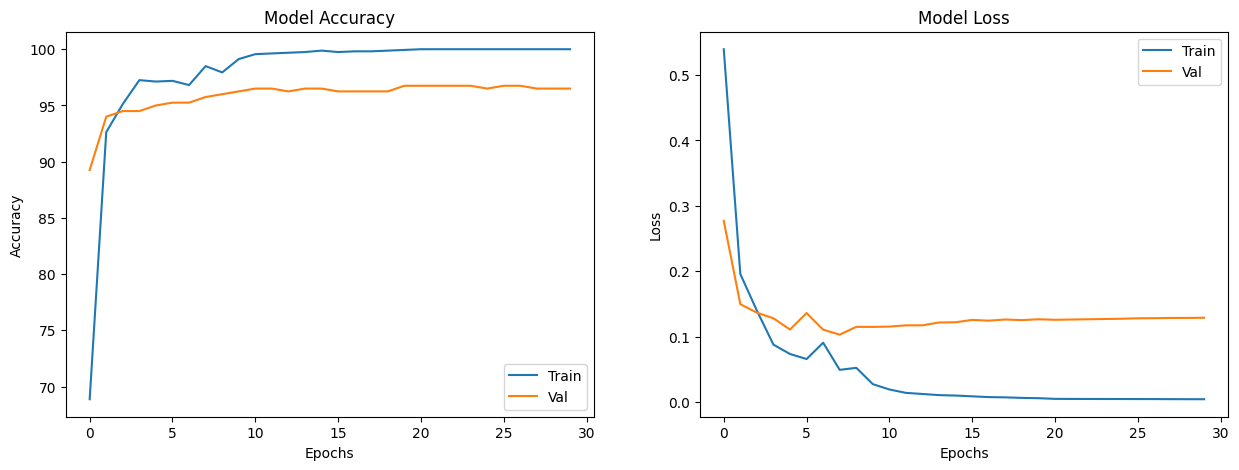

Test accuracy is 74.25%


In [47]:
time_model_ConvModel, model_ConvModel_list = training_time(model_ConvModel)

LinearModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


  3%|██▊                                                                                | 1/30 [00:00<00:26,  1.09it/s]

Epoch 1/30, Train loss: 0.6248, Train acc: 64.56%, Val loss: 0.4159, Val acc: 84.00%, Best Val loss: 0.4159 Best Val acc: 84.00%


  7%|█████▌                                                                             | 2/30 [00:01<00:22,  1.23it/s]

Epoch 2/30, Train loss: 0.3579, Train acc: 84.19%, Val loss: 0.2736, Val acc: 89.50%, Best Val loss: 0.2736 Best Val acc: 89.50%


 10%|████████▎                                                                          | 3/30 [00:02<00:23,  1.14it/s]

Epoch 3/30, Train loss: 0.2337, Train acc: 90.25%, Val loss: 0.2214, Val acc: 92.00%, Best Val loss: 0.2214 Best Val acc: 92.00%


 13%|███████████                                                                        | 4/30 [00:03<00:20,  1.24it/s]

Epoch 4/30, Train loss: 0.2077, Train acc: 91.81%, Val loss: 0.3598, Val acc: 86.00%, Best Val loss: 0.2214 Best Val acc: 92.00%


 17%|█████████████▊                                                                     | 5/30 [00:04<00:23,  1.08it/s]

Epoch 5/30, Train loss: 0.1845, Train acc: 92.75%, Val loss: 0.2106, Val acc: 91.50%, Best Val loss: 0.2106 Best Val acc: 92.00%


 20%|████████████████▌                                                                  | 6/30 [00:05<00:22,  1.04it/s]

Epoch 6/30, Train loss: 0.1629, Train acc: 93.94%, Val loss: 0.2337, Val acc: 90.50%, Best Val loss: 0.2106 Best Val acc: 92.00%


 23%|███████████████████▎                                                               | 7/30 [00:06<00:25,  1.10s/it]

Epoch 7/30, Train loss: 0.1721, Train acc: 93.31%, Val loss: 0.1782, Val acc: 93.50%, Best Val loss: 0.1782 Best Val acc: 93.50%


 27%|██████████████████████▏                                                            | 8/30 [00:08<00:26,  1.21s/it]

Epoch 8/30, Train loss: 0.1346, Train acc: 94.50%, Val loss: 0.1736, Val acc: 93.50%, Best Val loss: 0.1736 Best Val acc: 93.50%


 30%|████████████████████████▉                                                          | 9/30 [00:09<00:25,  1.21s/it]

Epoch 9/30, Train loss: 0.1341, Train acc: 95.06%, Val loss: 0.2269, Val acc: 90.25%, Best Val loss: 0.1736 Best Val acc: 93.50%


 33%|███████████████████████████▎                                                      | 10/30 [00:10<00:20,  1.04s/it]

Epoch 10/30, Train loss: 0.1416, Train acc: 94.69%, Val loss: 0.1705, Val acc: 93.25%, Best Val loss: 0.1705 Best Val acc: 93.50%


 37%|██████████████████████████████                                                    | 11/30 [00:11<00:19,  1.03s/it]

Epoch 11/30, Train loss: 0.1013, Train acc: 96.44%, Val loss: 0.1697, Val acc: 93.50%, Best Val loss: 0.1697 Best Val acc: 93.50%


 40%|████████████████████████████████▊                                                 | 12/30 [00:12<00:21,  1.18s/it]

Epoch 12/30, Train loss: 0.1001, Train acc: 96.44%, Val loss: 0.1699, Val acc: 93.75%, Best Val loss: 0.1697 Best Val acc: 93.75%


 43%|███████████████████████████████████▌                                              | 13/30 [00:13<00:19,  1.13s/it]

Epoch 13/30, Train loss: 0.0967, Train acc: 96.88%, Val loss: 0.1811, Val acc: 94.25%, Best Val loss: 0.1697 Best Val acc: 94.25%


 47%|██████████████████████████████████████▎                                           | 14/30 [00:14<00:16,  1.06s/it]

Epoch 14/30, Train loss: 0.0967, Train acc: 96.50%, Val loss: 0.1715, Val acc: 93.75%, Best Val loss: 0.1697 Best Val acc: 94.25%


 50%|█████████████████████████████████████████                                         | 15/30 [00:15<00:16,  1.10s/it]

Epoch 15/30, Train loss: 0.0972, Train acc: 96.75%, Val loss: 0.1753, Val acc: 94.25%, Best Val loss: 0.1697 Best Val acc: 94.25%


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:17<00:16,  1.15s/it]

Epoch 16/30, Train loss: 0.1033, Train acc: 96.31%, Val loss: 0.1756, Val acc: 93.50%, Best Val loss: 0.1697 Best Val acc: 94.25%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:18<00:16,  1.24s/it]

Epoch 17/30, Train loss: 0.0943, Train acc: 96.69%, Val loss: 0.1725, Val acc: 93.50%, Best Val loss: 0.1697 Best Val acc: 94.25%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:19<00:13,  1.13s/it]

Epoch 18/30, Train loss: 0.0963, Train acc: 96.81%, Val loss: 0.2046, Val acc: 94.00%, Best Val loss: 0.1697 Best Val acc: 94.25%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:20<00:12,  1.10s/it]

Epoch 19/30, Train loss: 0.0963, Train acc: 96.62%, Val loss: 0.1693, Val acc: 94.25%, Best Val loss: 0.1693 Best Val acc: 94.25%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:21<00:10,  1.06s/it]

Epoch 20/30, Train loss: 0.0929, Train acc: 96.69%, Val loss: 0.1702, Val acc: 94.00%, Best Val loss: 0.1693 Best Val acc: 94.25%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:22<00:10,  1.11s/it]

Epoch 21/30, Train loss: 0.0897, Train acc: 96.81%, Val loss: 0.1715, Val acc: 93.50%, Best Val loss: 0.1693 Best Val acc: 94.25%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:23<00:09,  1.13s/it]

Epoch 22/30, Train loss: 0.0895, Train acc: 97.12%, Val loss: 0.1706, Val acc: 93.75%, Best Val loss: 0.1693 Best Val acc: 94.25%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:24<00:07,  1.07s/it]

Epoch 23/30, Train loss: 0.0895, Train acc: 96.69%, Val loss: 0.1709, Val acc: 93.75%, Best Val loss: 0.1693 Best Val acc: 94.25%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:25<00:06,  1.01s/it]

Epoch 24/30, Train loss: 0.0896, Train acc: 97.00%, Val loss: 0.1709, Val acc: 93.75%, Best Val loss: 0.1693 Best Val acc: 94.25%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:26<00:05,  1.04s/it]

Epoch 25/30, Train loss: 0.0900, Train acc: 97.06%, Val loss: 0.1703, Val acc: 93.75%, Best Val loss: 0.1693 Best Val acc: 94.25%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:27<00:03,  1.03it/s]

Epoch 26/30, Train loss: 0.0909, Train acc: 96.88%, Val loss: 0.1702, Val acc: 94.25%, Best Val loss: 0.1693 Best Val acc: 94.25%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:28<00:02,  1.10it/s]

Epoch 27/30, Train loss: 0.0899, Train acc: 97.12%, Val loss: 0.1703, Val acc: 94.00%, Best Val loss: 0.1693 Best Val acc: 94.25%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:29<00:01,  1.01it/s]

Epoch 28/30, Train loss: 0.0895, Train acc: 96.75%, Val loss: 0.1713, Val acc: 93.75%, Best Val loss: 0.1693 Best Val acc: 94.25%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:30<00:01,  1.00s/it]

Epoch 29/30, Train loss: 0.0890, Train acc: 96.75%, Val loss: 0.1716, Val acc: 93.75%, Best Val loss: 0.1693 Best Val acc: 94.25%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.05s/it]

Epoch 30/30, Train loss: 0.0889, Train acc: 97.12%, Val loss: 0.1704, Val acc: 94.25%, Best Val loss: 0.1693 Best Val acc: 94.25%


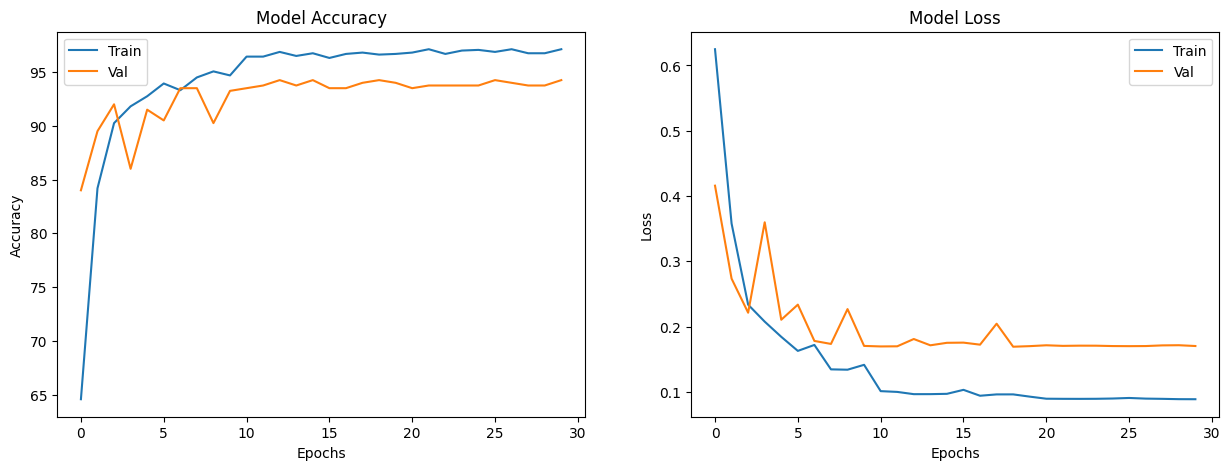

Test accuracy is 73.0%


In [48]:
time_model_LinearModel, model_LinearModel_list = training_time(model_LinearModel)

In [49]:
print(time_model_ConvModel)

75.25516176223755


In [50]:
print(time_model_LinearModel)

33.175148248672485


In [51]:
print(summary(model_ConvModel.to('cuda'), torch.zeros((1, 1, 256, 256)).to('cuda'), show_input=True))
print(summary(model_LinearModel.to('cuda'), torch.zeros((1, 1, 256, 256)).to('cuda'), show_input=True))

-------------------------------------------------------------------------
      Layer (type)           Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 1, 256, 256]             320             320
       MaxPool2d-2     [1, 32, 256, 256]               0               0
          Conv2d-3     [1, 32, 128, 128]           9,248           9,248
       MaxPool2d-4     [1, 32, 128, 128]               0               0
          Conv2d-5       [1, 32, 64, 64]           9,248           9,248
       MaxPool2d-6       [1, 32, 64, 64]               0               0
          Linear-7            [1, 32768]       1,048,608       1,048,608
          Linear-8               [1, 32]              33              33
Total params: 1,067,457
Trainable params: 1,067,457
Non-trainable params: 0
-------------------------------------------------------------------------
------------------------------------------------------------------------
      Layer (type)          Input Shape       

7.7 1.0339996133098164 test loss 
1.23%
18.5 1.002905561717657 test loss 
0.85%


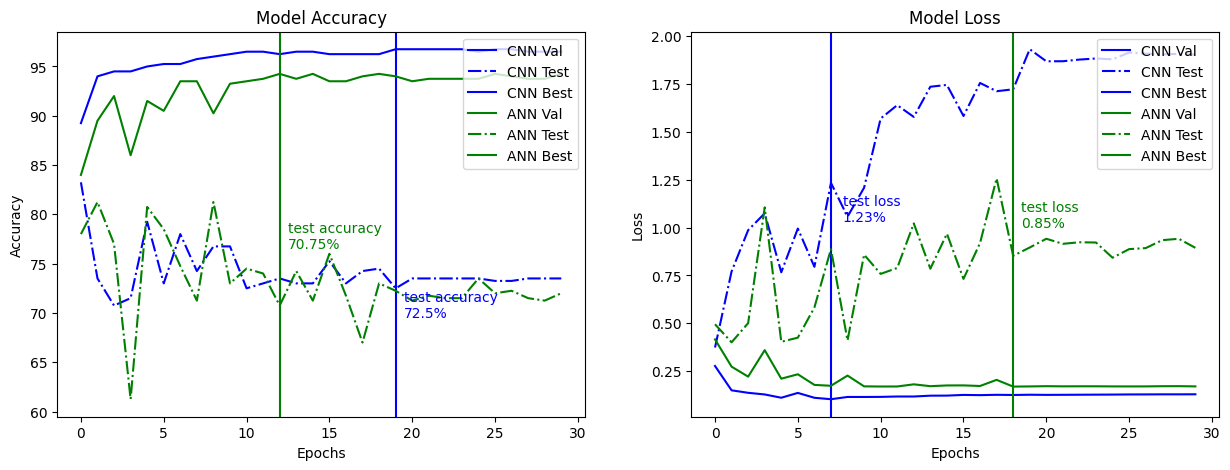

In [58]:
compare_generalization(model_ConvModel_list, model_LinearModel_list, 'CNN_vs_ANN', labels=['CNN Val', 'CNN Test', 'CNN Best', 'ANN Val', 'ANN Test', 'ANN Best'])

In [59]:
class ConvGAP_V3(nn.Module):
    def __init__(self, channel=32):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same') , # 256*256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128*128
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'), # 128*128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*64
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'), # 64*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*32
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'), # 32*32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16*16
            nn.Conv2d(256, channel, kernel_size=3, stride=1, padding='same'), # 16*16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8*8

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channel, 1)
        )

    def forward(self, x):

        x = self.net(x)
        return x

ConvGAP_V3(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 1204, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveAvgPool2d(output_size=1)
    (16): Flatten(start_dim=1, end_dim=-1)
    (1

  3%|██▊                                                                                | 1/30 [00:05<02:39,  5.49s/it]

Epoch 1/30, Train loss: 0.6929, Train acc: 50.31%, Val loss: 0.6849, Val acc: 75.75%, Best Val loss: 0.6849 Best Val acc: 75.75%


  7%|█████▌                                                                             | 2/30 [00:09<02:02,  4.37s/it]

Epoch 2/30, Train loss: 0.5996, Train acc: 71.69%, Val loss: 0.4342, Val acc: 81.25%, Best Val loss: 0.4342 Best Val acc: 81.25%


 10%|████████▎                                                                          | 3/30 [00:13<01:56,  4.30s/it]

Epoch 3/30, Train loss: 0.3230, Train acc: 86.50%, Val loss: 0.2318, Val acc: 90.50%, Best Val loss: 0.2318 Best Val acc: 90.50%


 13%|███████████                                                                        | 4/30 [00:17<01:48,  4.19s/it]

Epoch 4/30, Train loss: 0.2441, Train acc: 90.69%, Val loss: 0.1959, Val acc: 92.25%, Best Val loss: 0.1959 Best Val acc: 92.25%


 17%|█████████████▊                                                                     | 5/30 [00:21<01:45,  4.21s/it]

Epoch 5/30, Train loss: 0.2087, Train acc: 92.56%, Val loss: 0.1860, Val acc: 94.25%, Best Val loss: 0.1860 Best Val acc: 94.25%


 20%|████████████████▌                                                                  | 6/30 [00:25<01:37,  4.08s/it]

Epoch 6/30, Train loss: 0.2049, Train acc: 92.94%, Val loss: 0.1771, Val acc: 93.50%, Best Val loss: 0.1771 Best Val acc: 94.25%


 23%|███████████████████▎                                                               | 7/30 [00:29<01:35,  4.17s/it]

Epoch 7/30, Train loss: 0.1485, Train acc: 94.44%, Val loss: 0.1703, Val acc: 94.50%, Best Val loss: 0.1703 Best Val acc: 94.50%


 27%|██████████████████████▏                                                            | 8/30 [00:33<01:30,  4.12s/it]

Epoch 8/30, Train loss: 0.1441, Train acc: 95.00%, Val loss: 0.1490, Val acc: 94.25%, Best Val loss: 0.1490 Best Val acc: 94.50%


 30%|████████████████████████▉                                                          | 9/30 [00:37<01:25,  4.05s/it]

Epoch 9/30, Train loss: 0.1578, Train acc: 94.44%, Val loss: 0.1868, Val acc: 93.00%, Best Val loss: 0.1490 Best Val acc: 94.50%


 33%|███████████████████████████▎                                                      | 10/30 [00:41<01:21,  4.07s/it]

Epoch 10/30, Train loss: 0.1374, Train acc: 94.81%, Val loss: 0.1586, Val acc: 93.75%, Best Val loss: 0.1490 Best Val acc: 94.50%


 37%|██████████████████████████████                                                    | 11/30 [00:45<01:16,  4.05s/it]

Epoch 11/30, Train loss: 0.0996, Train acc: 96.62%, Val loss: 0.1466, Val acc: 94.50%, Best Val loss: 0.1466 Best Val acc: 94.50%


 40%|████████████████████████████████▊                                                 | 12/30 [00:50<01:14,  4.13s/it]

Epoch 12/30, Train loss: 0.1001, Train acc: 96.44%, Val loss: 0.1821, Val acc: 93.25%, Best Val loss: 0.1466 Best Val acc: 94.50%


 43%|███████████████████████████████████▌                                              | 13/30 [00:54<01:11,  4.20s/it]

Epoch 13/30, Train loss: 0.0953, Train acc: 96.62%, Val loss: 0.1684, Val acc: 93.75%, Best Val loss: 0.1466 Best Val acc: 94.50%


 47%|██████████████████████████████████████▎                                           | 14/30 [00:58<01:05,  4.08s/it]

Epoch 14/30, Train loss: 0.0861, Train acc: 97.25%, Val loss: 0.1546, Val acc: 94.50%, Best Val loss: 0.1466 Best Val acc: 94.50%


 50%|█████████████████████████████████████████                                         | 15/30 [01:02<01:02,  4.16s/it]

Epoch 15/30, Train loss: 0.0867, Train acc: 97.12%, Val loss: 0.1767, Val acc: 93.75%, Best Val loss: 0.1466 Best Val acc: 94.50%


 53%|███████████████████████████████████████████▋                                      | 16/30 [01:06<00:58,  4.16s/it]

Epoch 16/30, Train loss: 0.0876, Train acc: 97.00%, Val loss: 0.1720, Val acc: 93.75%, Best Val loss: 0.1466 Best Val acc: 94.50%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [01:10<00:54,  4.17s/it]

Epoch 17/30, Train loss: 0.0820, Train acc: 97.25%, Val loss: 0.1501, Val acc: 95.00%, Best Val loss: 0.1466 Best Val acc: 95.00%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [01:15<00:50,  4.24s/it]

Epoch 18/30, Train loss: 0.0806, Train acc: 97.38%, Val loss: 0.1481, Val acc: 95.25%, Best Val loss: 0.1466 Best Val acc: 95.25%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [01:19<00:47,  4.29s/it]

Epoch 19/30, Train loss: 0.0789, Train acc: 97.44%, Val loss: 0.1442, Val acc: 95.00%, Best Val loss: 0.1442 Best Val acc: 95.25%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [01:24<00:43,  4.30s/it]

Epoch 20/30, Train loss: 0.0789, Train acc: 97.38%, Val loss: 0.1498, Val acc: 95.00%, Best Val loss: 0.1442 Best Val acc: 95.25%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [01:28<00:38,  4.23s/it]

Epoch 21/30, Train loss: 0.0712, Train acc: 97.56%, Val loss: 0.1529, Val acc: 95.25%, Best Val loss: 0.1442 Best Val acc: 95.25%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [01:32<00:33,  4.24s/it]

Epoch 22/30, Train loss: 0.0710, Train acc: 97.75%, Val loss: 0.1529, Val acc: 95.00%, Best Val loss: 0.1442 Best Val acc: 95.25%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [01:36<00:30,  4.29s/it]

Epoch 23/30, Train loss: 0.0708, Train acc: 97.56%, Val loss: 0.1501, Val acc: 95.25%, Best Val loss: 0.1442 Best Val acc: 95.25%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [01:41<00:26,  4.37s/it]

Epoch 24/30, Train loss: 0.0703, Train acc: 97.62%, Val loss: 0.1536, Val acc: 95.50%, Best Val loss: 0.1442 Best Val acc: 95.50%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [01:45<00:21,  4.37s/it]

Epoch 25/30, Train loss: 0.0707, Train acc: 97.62%, Val loss: 0.1553, Val acc: 95.50%, Best Val loss: 0.1442 Best Val acc: 95.50%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [01:50<00:17,  4.40s/it]

Epoch 26/30, Train loss: 0.0701, Train acc: 97.62%, Val loss: 0.1546, Val acc: 95.50%, Best Val loss: 0.1442 Best Val acc: 95.50%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [01:54<00:13,  4.40s/it]

Epoch 27/30, Train loss: 0.0704, Train acc: 97.62%, Val loss: 0.1544, Val acc: 95.50%, Best Val loss: 0.1442 Best Val acc: 95.50%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [01:58<00:08,  4.35s/it]

Epoch 28/30, Train loss: 0.0696, Train acc: 97.62%, Val loss: 0.1530, Val acc: 95.00%, Best Val loss: 0.1442 Best Val acc: 95.50%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [02:03<00:04,  4.35s/it]

Epoch 29/30, Train loss: 0.0693, Train acc: 97.81%, Val loss: 0.1481, Val acc: 95.00%, Best Val loss: 0.1442 Best Val acc: 95.50%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:07<00:00,  4.25s/it]

Epoch 30/30, Train loss: 0.0696, Train acc: 97.56%, Val loss: 0.1554, Val acc: 95.50%, Best Val loss: 0.1442 Best Val acc: 95.50%


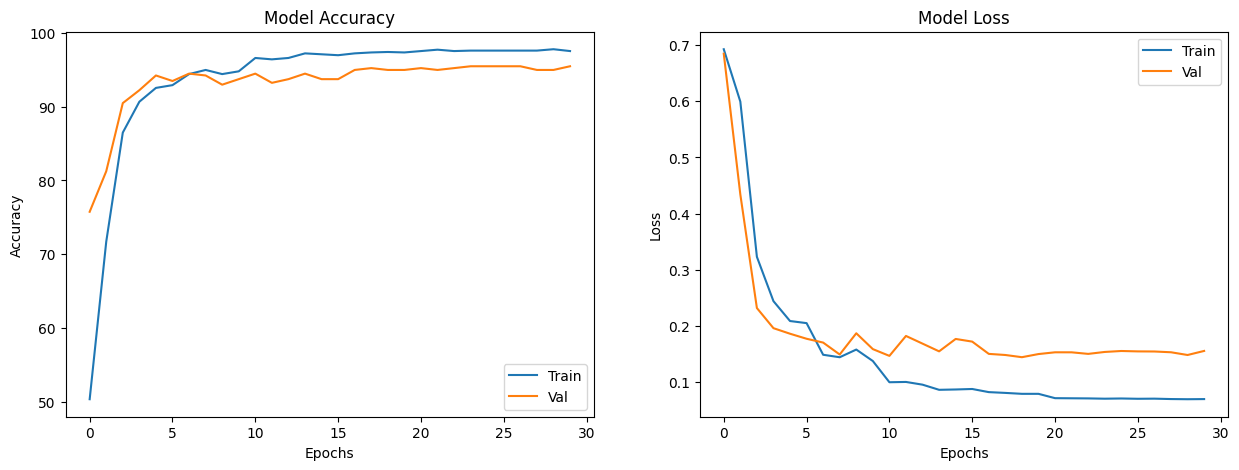

Test accuracy is 66.5%


In [60]:
# Original ConvModel

model_ConvGAP_V3_1024 = ConvGAP_V3(channel=1204)

m_ConvGAP_V3_1024 = training(model=model_ConvGAP_V3_1024, epochs=30, serial_no='model_ConvGAP_V3_1024_002')

In [61]:
print(summary(model_ConvGAP_V3_1024.to('cuda'), torch.zeros((1, 1, 256, 256)).to('cuda'), show_input=True))

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 1, 256, 256]             320             320
                 ReLU-2     [1, 32, 256, 256]               0               0
            MaxPool2d-3     [1, 32, 256, 256]               0               0
               Conv2d-4     [1, 32, 128, 128]          18,496          18,496
                 ReLU-5     [1, 64, 128, 128]               0               0
            MaxPool2d-6     [1, 64, 128, 128]               0               0
               Conv2d-7       [1, 64, 64, 64]          73,856          73,856
                 ReLU-8      [1, 128, 64, 64]               0               0
            MaxPool2d-9      [1, 128, 64, 64]               0               0
              Conv2d-10      [1, 128, 32, 32]         295,168         295,168
                ReLU-11      [1, 256, 32, 32]               0  

29.7 0.420369934118711 test loss 
0.62%
18.5 1.4434090624061913 test loss 
1.29%


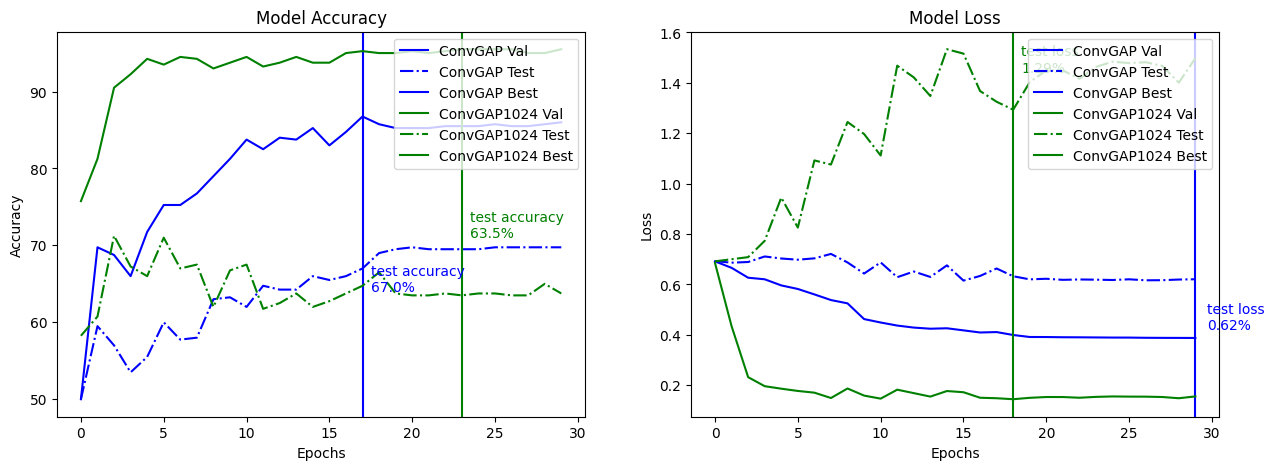

In [64]:
compare_generalization(m_ConvGAP_original, m_ConvGAP_V3_1024, 'CNN_vs_ANN', labels=['ConvGAP Val', 'ConvGAP Test', 'ConvGAP Best', 'ConvGAP1024 Val', 'ConvGAP1024 Test', 'ConvGAP1024 Best'])

29.7 0.420369934118711 test loss 
0.62%
29.5 0.8021706586846938 test loss 
0.65%


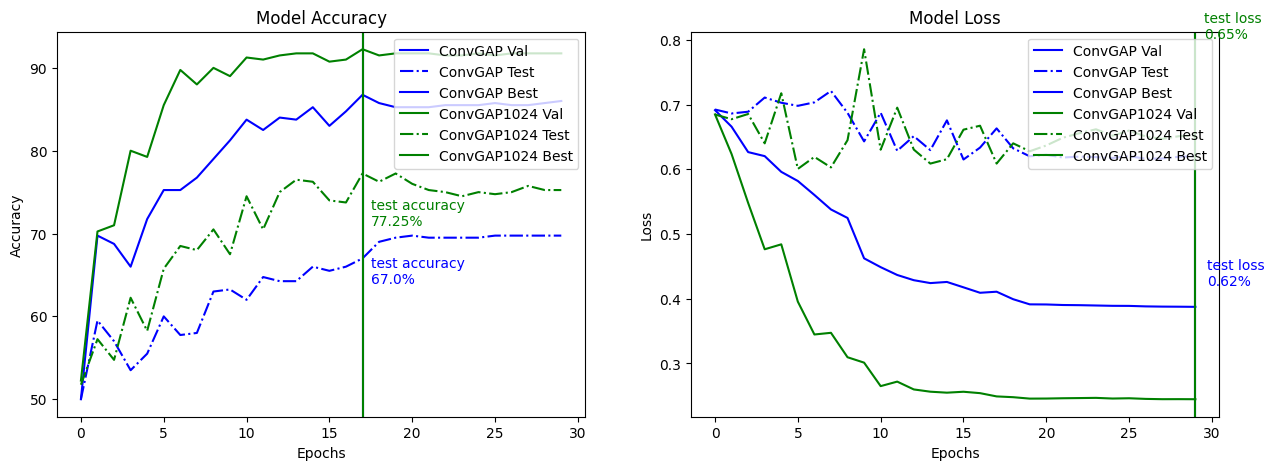

In [71]:
compare_generalization(m_ConvGAP_original, m_ConvGAP_V2_1024, 'ConvGAP_1_vs_1024', labels=['ConvGAP Val', 'ConvGAP Test', 'ConvGAP Best', 'ConvGAP1024 Val', 'ConvGAP1024 Test', 'ConvGAP1024 Best'])

ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


  3%|██▊                                                                                | 1/30 [00:02<01:20,  2.79s/it]

Epoch 1/30, Train loss: 0.0552, Train acc: 97.88%, Val loss: 0.1094, Val acc: 96.25%, Best Val loss: 0.1094 Best Val acc: 96.25%


  7%|█████▌                                                                             | 2/30 [00:04<01:08,  2.43s/it]

Epoch 2/30, Train loss: 0.0582, Train acc: 98.06%, Val loss: 0.1168, Val acc: 95.50%, Best Val loss: 0.1094 Best Val acc: 96.25%


 10%|████████▎                                                                          | 3/30 [00:07<01:02,  2.30s/it]

Epoch 3/30, Train loss: 0.0715, Train acc: 97.38%, Val loss: 0.1131, Val acc: 95.25%, Best Val loss: 0.1094 Best Val acc: 96.25%


 13%|███████████                                                                        | 4/30 [00:09<00:57,  2.21s/it]

Epoch 4/30, Train loss: 0.0579, Train acc: 97.94%, Val loss: 0.1096, Val acc: 95.75%, Best Val loss: 0.1094 Best Val acc: 96.25%


 17%|█████████████▊                                                                     | 5/30 [00:11<00:51,  2.08s/it]

Epoch 5/30, Train loss: 0.0639, Train acc: 97.75%, Val loss: 0.1314, Val acc: 94.75%, Best Val loss: 0.1094 Best Val acc: 96.25%


 20%|████████████████▌                                                                  | 6/30 [00:13<00:51,  2.15s/it]

Epoch 6/30, Train loss: 0.0568, Train acc: 98.25%, Val loss: 0.1639, Val acc: 94.50%, Best Val loss: 0.1094 Best Val acc: 96.25%


 23%|███████████████████▎                                                               | 7/30 [00:15<00:47,  2.07s/it]

Epoch 7/30, Train loss: 0.0548, Train acc: 98.25%, Val loss: 0.1333, Val acc: 94.50%, Best Val loss: 0.1094 Best Val acc: 96.25%


 27%|██████████████████████▏                                                            | 8/30 [00:17<00:45,  2.05s/it]

Epoch 8/30, Train loss: 0.0579, Train acc: 98.12%, Val loss: 0.1065, Val acc: 96.00%, Best Val loss: 0.1065 Best Val acc: 96.25%


 30%|████████████████████████▉                                                          | 9/30 [00:19<00:44,  2.13s/it]

Epoch 9/30, Train loss: 0.0448, Train acc: 98.38%, Val loss: 0.1076, Val acc: 94.50%, Best Val loss: 0.1065 Best Val acc: 96.25%


 33%|███████████████████████████▎                                                      | 10/30 [00:21<00:42,  2.14s/it]

Epoch 10/30, Train loss: 0.0638, Train acc: 97.88%, Val loss: 0.1235, Val acc: 95.75%, Best Val loss: 0.1065 Best Val acc: 96.25%


 37%|██████████████████████████████                                                    | 11/30 [00:23<00:40,  2.14s/it]

Epoch 11/30, Train loss: 0.0414, Train acc: 98.88%, Val loss: 0.1056, Val acc: 96.00%, Best Val loss: 0.1056 Best Val acc: 96.25%


 40%|████████████████████████████████▊                                                 | 12/30 [00:26<00:38,  2.15s/it]

Epoch 12/30, Train loss: 0.0327, Train acc: 99.38%, Val loss: 0.1070, Val acc: 96.00%, Best Val loss: 0.1056 Best Val acc: 96.25%


 43%|███████████████████████████████████▌                                              | 13/30 [00:28<00:36,  2.16s/it]

Epoch 13/30, Train loss: 0.0289, Train acc: 99.25%, Val loss: 0.1056, Val acc: 96.25%, Best Val loss: 0.1056 Best Val acc: 96.25%


 47%|██████████████████████████████████████▎                                           | 14/30 [00:30<00:35,  2.24s/it]

Epoch 14/30, Train loss: 0.0274, Train acc: 99.44%, Val loss: 0.1049, Val acc: 96.00%, Best Val loss: 0.1049 Best Val acc: 96.25%


 50%|█████████████████████████████████████████                                         | 15/30 [00:32<00:33,  2.25s/it]

Epoch 15/30, Train loss: 0.0276, Train acc: 99.31%, Val loss: 0.1029, Val acc: 96.00%, Best Val loss: 0.1029 Best Val acc: 96.25%


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:35<00:31,  2.23s/it]

Epoch 16/30, Train loss: 0.0272, Train acc: 99.50%, Val loss: 0.1031, Val acc: 95.75%, Best Val loss: 0.1029 Best Val acc: 96.25%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:37<00:28,  2.17s/it]

Epoch 17/30, Train loss: 0.0253, Train acc: 99.62%, Val loss: 0.1023, Val acc: 96.25%, Best Val loss: 0.1023 Best Val acc: 96.25%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:39<00:26,  2.17s/it]

Epoch 18/30, Train loss: 0.0257, Train acc: 99.56%, Val loss: 0.1002, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:41<00:24,  2.19s/it]

Epoch 19/30, Train loss: 0.0255, Train acc: 99.50%, Val loss: 0.1016, Val acc: 95.75%, Best Val loss: 0.1002 Best Val acc: 96.25%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:43<00:22,  2.22s/it]

Epoch 20/30, Train loss: 0.0240, Train acc: 99.56%, Val loss: 0.1020, Val acc: 95.75%, Best Val loss: 0.1002 Best Val acc: 96.25%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:46<00:20,  2.23s/it]

Epoch 21/30, Train loss: 0.0223, Train acc: 99.62%, Val loss: 0.1020, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:48<00:17,  2.19s/it]

Epoch 22/30, Train loss: 0.0222, Train acc: 99.69%, Val loss: 0.1014, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:50<00:15,  2.23s/it]

Epoch 23/30, Train loss: 0.0221, Train acc: 99.62%, Val loss: 0.1014, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:52<00:13,  2.26s/it]

Epoch 24/30, Train loss: 0.0222, Train acc: 99.69%, Val loss: 0.1013, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:55<00:11,  2.26s/it]

Epoch 25/30, Train loss: 0.0223, Train acc: 99.69%, Val loss: 0.1014, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:57<00:08,  2.25s/it]

Epoch 26/30, Train loss: 0.0222, Train acc: 99.69%, Val loss: 0.1011, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:59<00:06,  2.28s/it]

Epoch 27/30, Train loss: 0.0221, Train acc: 99.75%, Val loss: 0.1013, Val acc: 96.25%, Best Val loss: 0.1002 Best Val acc: 96.25%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [01:01<00:04,  2.23s/it]

Epoch 28/30, Train loss: 0.0220, Train acc: 99.69%, Val loss: 0.1014, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [01:04<00:02,  2.24s/it]

Epoch 29/30, Train loss: 0.0219, Train acc: 99.69%, Val loss: 0.1009, Val acc: 95.75%, Best Val loss: 0.1002 Best Val acc: 96.25%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:06<00:00,  2.21s/it]

Epoch 30/30, Train loss: 0.0222, Train acc: 99.56%, Val loss: 0.1011, Val acc: 96.00%, Best Val loss: 0.1002 Best Val acc: 96.25%


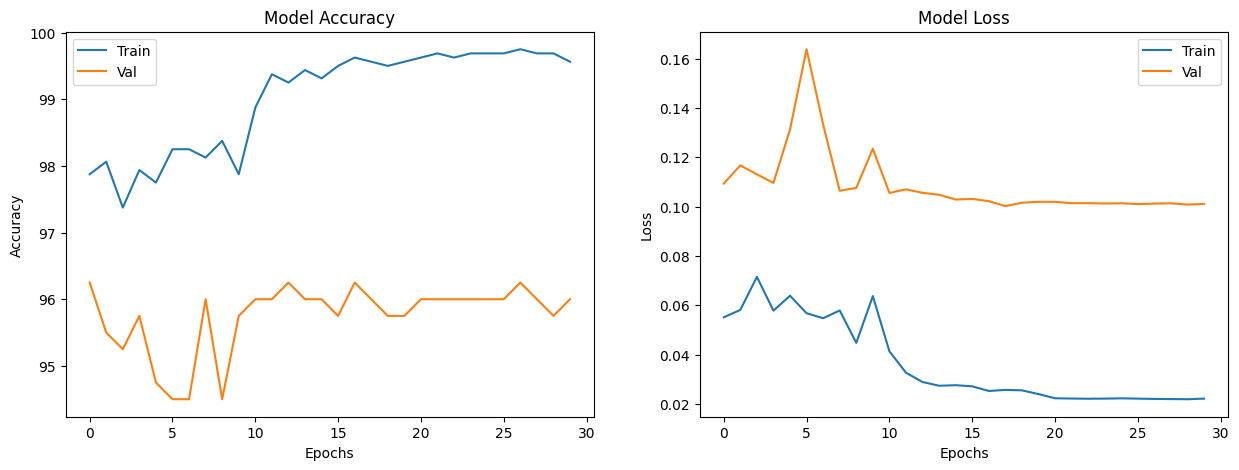

Test accuracy is 75.25%


In [79]:
model_ConvModel_wd01_list = training(model=model_ConvModel, epochs=30, weight_decay=0.01)

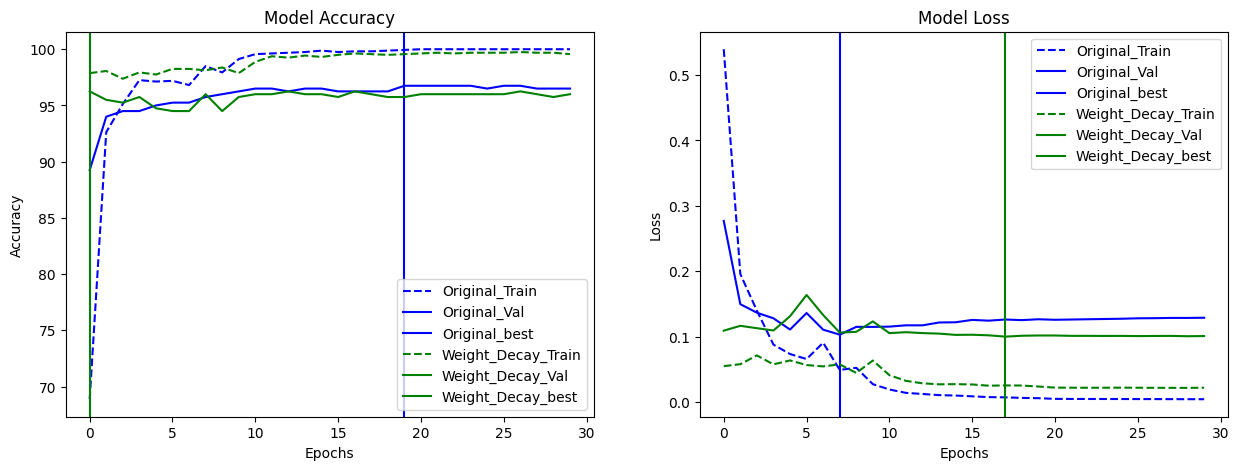

In [80]:
compare_learning_curve(model_ConvModel_list, model_ConvModel_wd01_list, serial_no='012', labels=None)

7.7 1.0339996133098164 test loss 
1.23%
17.5 1.2126862280321522 test loss 
1.06%


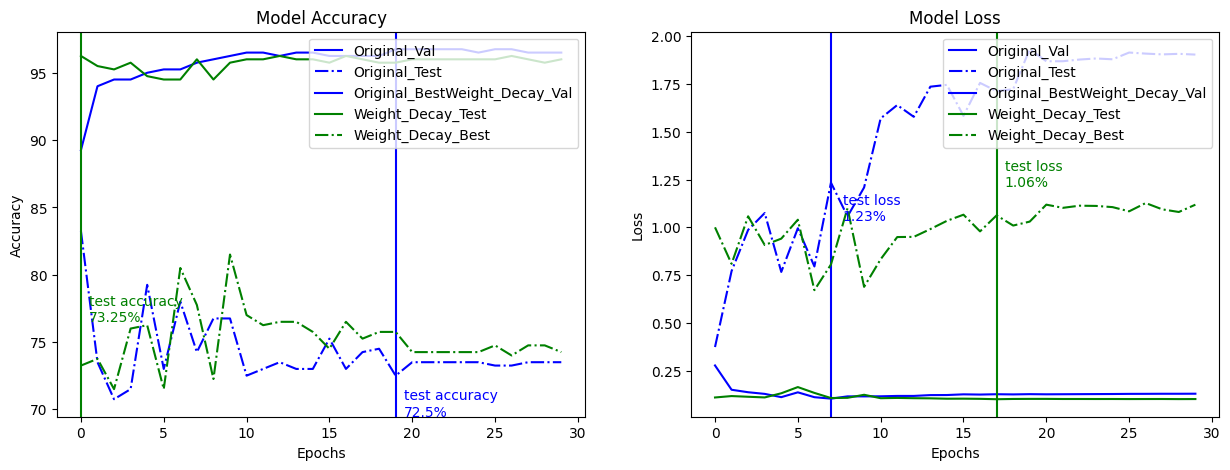

In [81]:
compare_generalization(model_ConvModel_list, model_ConvModel_wd01_list, serial_no='012', labels=None)